# <center> Sentiment Analysis of Three Major Hospitals in Thailand using Deep Learning

## <b>Introduction</b>

<p>
    Nowsaday, internet is very easy to access for all people which make general population communicate easier than before. One of the most popular way of communication is through social media. This generates huge amount of data every day which could be use for decision-making. If data are used and analyzed properly, it provides an edge to the business by understanding customers behavior, resource allocation, provide better services to the customers, personalized promotion and advertisement and etc. 
</p>
<img src="images/data_generated.gif" width="800" height="600">
<p>
    One popular method that could help understand the customer's behaviour is using sentiment analysis. This method mine the text data in the social media which help the business to identify the strength and weakness of the product or services. With the rapid advancement in deep learning, the ability of the algorithm to understand and analyze text accurately has improved dramatically.
<p>
<p>
    The aim of this assignment is to use create a model using state-of-art deep learning to find the sentiment of the customers who use service from Ramathibodi hospital, Siriraj hospital and Chula hospital. The word cloud will be use to identify important words that could be use to improve their services.
    </p>

## <b>Methodology</b>

1) <b> Web Scraping </b><br>
We perform data retrieval from https://www.honestdocs.co/ to obtain comments on three hospitals, Ramathibodi hospital, Siriraj hospital and Chulalongkorn hospital.
<br>

2) <b> Language Translation </b><br>
Translate Thai to English word using googletrans package.
<br>
** The processes have been done and stored in csv file because of limit number of translation allowed by googletrans package.
<br>

3) <b> Data Preprocessing </b><br>
- <i> Remove Duplicate </i>
<br>Some comments are duplciate while retrieving data.
<br>

- <i> Word normalization </i>
<br> Convert short English form into full English.<br>
<br>
- <i> Balance data </i>
<br> Transform data into binary label, positive and negative comments. Balance the dataset to have same number of positive and negative comments.
<br>

- <i> Tokenization </i>
<br> Convert sentence into words to perform other word preprocessing.<br>
<br>
- <i> Remove acronyms, emoticon, conjunction </i><br>
<br>

- <i> Remove stopwords </i>
<br> Remove word that is commonly used to reduce number of words which help to increase processing time.<br>
<br>

- <i> Word stemming/infecltion </i>
<br> Convert inflected words into the same form.<br>
<br>

- <i> Remove number </i><br>
<br>

- <i> Text to sequence </i><br>
Perform text to sequence in order for computer to able to process.<br>
<br>

- <i> Sequence padding </i>
<br> Make all the comments to have the same length.

4) <b> Data Preparation </b><br>
- <i> Split data into three datasets: 
    - Training set - Model training
    - Validation set - Hyperparamter tuning
    - Test set - Model testing

5) <b> Model Building </b><br>
We perform 2 models LSTM and GRU to find which model give better prediction. We will use pretrained model GloVe to see whether it will help to increase the model performance.

> <br><b><i> LSTM </i></b>
- Gridsearch to tune hyperparameters.
- Test sigmoid vs softmax as an activation function.
- Find the best weight to be use for prediction.
- Use pretrain word vector GloVe and compare the performance.

> <br><b><i> GRU </i></b>
- Gridsearch to tune hyperparameters.

6) <b> Model Evaluation </b><br>
- Compare between LSTM and GRU in term of Accuracy, ROC and PR cruve.

7) <b> Analysis on Error </b><br>
- Misclassification predicted by both model will be analyzed to find the pattern of error.

8) <b> Wordclud </b><br>
- Visualize the most common words from the predicted negative label using term frequency.


In [1]:
# Libraries for webscraping
import requests
from bs4 import BeautifulSoup
# from googletrans import Translator
from textblob import TextBlob
from time import time

# Libraries for data analysis and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statistics

# Libraries for model creation
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.externals import joblib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
import keras
from tensorflow import set_random_seed
from sklearn.externals import joblib
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

#Library for wordcloud
from collections import Counter
from wordcloud import WordCloud

D:\Users\Nugliar\Anaconda3\envs\keras_cpu\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.


<font color='red'>
    
### -----------------------------------------------------------------------------------------------------------------------------------------------------
### Due to limited usage of googletrans API, I have use googletrans from google spreadsheet instead as it allows larger number of translations.
### Please, skip the webscraping and translation codes and start at import data section. 
### -----------------------------------------------------------------------------------------------------------------------------------------------------

</font>

### <i>Web Scraping

In [1]:
'''
Function for scarping from www.honestdocs.co

Parameters-
url: url from www.honestdocs.co
hosp_name: variable name for column hospital to indicate where the data come from
'''
def scraping(url, hosp_name):
    data = requests.get(url)
    print(data.status_code) #2: success 4,5: error
    
    comment = []
    score = []
    for i in range(1,100):
        r = requests.get(url, params=dict(query='web scraping',page=i))
        soup = BeautifulSoup(r.text,'html.parser')
        n = len(soup.find_all('div',{'class':'comments__content'}))
        for i in range(0,n):
            comment.append(soup.find_all('div',{'class':'comments__content'})[i].get_text().lstrip().strip())
            score.append(soup.find_all('span',{'class':'stars star-rating'})[i].attrs['data-score'])
            i +=1
        i +=1
        if len(soup.find_all('div',{'class':'comments__content'})) <= 0:
            break
        
    data = pd.DataFrame(comment)
    data['score'] = score
    data['hospital'] = hosp_name
    return data

rama = scraping('https://www.honestdocs.co/hospitals/ramathibodi-hospital', 'Rama')
siriraj = scraping('https://www.honestdocs.co/hospitals/siriraj-hospital', 'Siriraj')
chula = scraping('https://www.honestdocs.co/hospitals/king-chulalongkorn-memorial-hospital', 'Chula') 

NameError: name 'requests' is not defined

In [1]:
rama.to_csv('dataset/rama.csv', index=False, encoding='utf8', sep = '\t')
siriraj.to_csv('dataset/siriraj.csv', index=False, encoding='utf8', sep = '\t')
chula.to_csv('dataset/chula.csv', index=False, encoding='utf8', sep = '\t')

NameError: name 'rama' is not defined

In [ ]:
all_hosp = pd.concat([rama, siriraj, chula])
all_hosp = all_hosp.reset_index(drop=True)
all_hosp.to_csv('dataset/all_hosp.csv', index=False, encoding='utf8', sep = '"')

In [2]:
all_hosp.head()

NameError: name 'all_hosp' is not defined

### <i>Translate

>Due to limited number of translation allowed using googletrans API, I could not be able to translate all of the sentence in one go. <br>
So, the solution is to use excel from google sheet and use function =translate() to translate remaining sentences. <br>
Therefore, the code below is not used but just illustrate that we can perform translation using this method.

In [23]:
comment_eng = []
translator = Translator()
for i in range(0,len(all_hosp)):
   comment_eng.append(translator.translate(all_hosp[0][i]).text)
   i +=1

print('comment: '+ str(len(comment)))
print('comment_eng: '+ str(len(comment_eng)))
print('score: '+ str(len(score)))

all_hosp['comment_eng'] = comment_eng
all_hosp.to_csv('dataset/all_hosp.csv', index=False)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

### <i>Import

In [2]:
# Set dataframe display

pd.set_option('display.max_columns', 10)  # default = 20
pd.set_option('display.expand_frame_repr', True) # default = True
pd.set_option('display.max_colwidth', -1) # default = 50

In [4]:
#Import each data from each hospital
df_rama = pd.read_csv(r'dataset\comment_eng_score.csv')
df_siriraj = pd.read_csv(r'dataset\siriraj - siriraj.tsv', sep='\t')
df_chula = pd.read_csv(r'dataset\chula - chula.tsv', sep='\t')

#Concate all of them into single dataframe
df_all_hos = pd.concat([df_rama, df_siriraj, df_chula])
df_all_hos = df_all_hos.reset_index(drop=True)
df_all_hos = df_all_hos.drop_duplicates()

#Export
df_all_hos.to_csv('dataset/all_hosp.csv', index=False, sep='\t') 

In [4]:
#Import
full_eng = pd.read_csv('dataset/all_hosp.csv', sep='\t')
full_eng_col = full_eng.columns.to_list()
full_eng_col = ['2', '0', '1', '3']
full_eng = full_eng[full_eng_col]
full_eng

,2,0,1,3
0,"I used to go to LASIK here. Very good. Now, it has been 2 years since it has no effect. And the price is also good. The cut may look scary. But when it was really time to do it, it didn't hurt. Because there was a drop of anesthetic before dissection",ผมเคยไปทำเลสิกที่นี้ ดีมากครับตอนนี้ผ่ามาจะ2ปีแล้วยังไม่มีผลค้างเคียงอะไรและราคาก็ถูกดีด้วย ตอนผ่าอาจจะดูน่ากลัวไปซะหน่อย แต่พอถึงเวลาผ่าจริงๆแล้วไม่รู้สึกเจ็บเลยครับ เพราะมีการหยอดยาชาก่อนผ่า,4,rama
1,"Maintained for many years since the age of 14 Will now have a bachelor's degree From sleeping in the midst of the arthropod until he recovered, he could live a normal life. In particular, premium clinics do not have to wait for a long time. There are convenient, fast, every step from paying to dispensing. The treatment fee is not too expensive when compared to many private services that are very good. Want everyone to come here",รักษามาหลายปีแล้วตั้งแต่อายุ14 ตอนนี้จะจบปริญญาตรีแล้ว ตั้งแต่นอนแอดมิดที่ รพ จนหายดีออกมาใช้ชีวิตได้เป็นปกติ โดยเฉพาะคลินิกพรีเมี่ยม ไม่ต้องรอนาน มีความสะดวกรวดเร็วทุกขั้นตอนตั้งแต่จ่ายเงินไปถึงจ่ายยา ค่ารักษาไม่ได้แพงเกินไปเมื่อเทียบเท่ากับเอกชนหลายๆที่ บริการดีมากๆ คุณหมอดูแลเอาใจใส่ดี อยากให้ทุกคนมารักษาที่นี่,5,rama
2,"At the 2nd floor of Phra Thep building, the place looks modern.\rBut at the pressure measuring room There are people at the temple (thinking that it's not a nurse because wearing a purple dress) likes to scold people who come to the temple. Speak stiffly to people who come to measure pressure. In spite of the other nurses who put on a nursing gown, said because Want to improve\r Come to the doctor at the surgery department Dr. Tawut, then told to have surgery. Just saying that he had to surgery to be healed at that time, he was shocked about the surgery. And the fog went, not really telling what was the distance (Roi-Laem) and then meeting The nurse at Nuek Kyu doesn't care when we repeat what he says is correct. Just saying that In conclusion, it seems to be good, but waiting to see the surgery before",ที่ตึกพระเทพชั้น 2 สถานที่เครื่องมือดูทันสมัย \rแต่ที่ห้องวัดความดัน มีคนที่วัด(คิดว่าไม่ใช่พยาบาลเพราะใส่ชุดสีม่วง) ชอบดุคนที่มาวัด พูดเสียงแข็งใส่คนที่มาวัดความดัน ทั้งๆที่พยาบาลอีกคนที่ใส่ชุดพยาบาลพูดเพราะ อยากให้ปรับปรุง \r มาหาหมอที่แผนกศัลยกรรม อาจารย์หมอตรวตแล้วบอกต้องผ่าตัด บอกแค่ว่าต้องผ่าตัดถึงจะหายตอนนั้นช็อคเรื่องผ่าตัดอยู่เลยไม่ได้ถามอะไรเลย แล้วหมอกก็ไปเลยไม่ได้บอกว่าจริงๆเป็นอะไร ระยะไหน (ริดสีดวง) แล้วก็นัดวันผ่า พยาบาลที่นัดคิวก็ไม่สนเวลาเราทวนสิ่งที่บอกมาว่าถูกต้องไหม บอกแค่ว่าตามนั้นแหละ สรุปแล้วเหมือนจะดีแต่รอดูช่วงผ่าตัดก่อน,3,rama
3,"Its a public hospital so service is bad (nurses are completely unfriendly and doctors have god complex plus horrifying bed side manner) but they will keep you alive (nothing to do with quality of life) with decent drug collection. Young doctors are generally very friendly but they are busy all the time due to the amount of patients (like canned tuna) so don't expect them to spend too much time diagnosing you. You have to come early in the morning to ensure you're in queue and the wait 1-2 (bad days) hours behind schedule to get to see the doctor for < 15 min or less (all together door to door 8-9hrs). \r Additionally you can call all the 8 numbers on the websites from normal clinic to Premium and wait 15 minutes on each number just for them to hang up on you or divert you elsewhere then hang up on you.....\r Worst are the guys doing the schedule because they are very consistent in demonstrating the inability to manage schedules (or not) because you will ""always"" have to wait 1-2 hours ""after"" your appointment schedule to see the doctor but they also cant tell you that so you cant go anywhere and have to hang around the front door. \r In the better days you will get to sit inside the doctor's room to wait because the doctor is no where to be found and nobody will know when he/she will come back. If you ask the nurse they will give you the ""i dont know and I couldnt care 

### <i>Preprocessing

#### Drop duplicate

In [5]:
# There are some duplicate comments during scraping

full_eng2 = full_eng.drop_duplicates()
full_eng = full_eng.drop_duplicates()
full_eng2 = full_eng2.reset_index(drop=True)

In [6]:
print('There are a total of', len(full_eng), 'comments from all three hospitals')

There are a total of 647 comments from all three hospitals


#### Convert into full term

In [7]:
appos = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [8]:
# We want to convert from short form english to full form by replacing them

full = full_eng2.iloc[:,0]
sen = []
for i in full:
    full2 = []
    full2.append(i.split())
    full_sen = []
    for j in range(len(full2)):
        for k in range(len(full2[j])):
            if full2[j][k] in appos:
                full_sen.append(appos[full2[j][k]])
            else:
                full_sen.append(full2[j][k])       
    sen.append(full_sen)

sen2 = []
for i in range(len(sen)):    
    sen2.append(" ".join(sen[i]))

full_eng2 = pd.DataFrame(sen2)
#full_eng3[1] = pd.to_numeric(full_eng3[1])

full_eng2.head()

,0
0,"I used to go to LASIK here. Very good. Now, it has been 2 years since it has no effect. And the price is also good. The cut may look scary. But when it was really time to do it, it did not hurt. Because there was a drop of anesthetic before dissection"
1,"Maintained for many years since the age of 14 Will now have a bachelor's degree From sleeping in the midst of the arthropod until he recovered, he could live a normal life. In particular, premium clinics do not have to wait for a long time. There are convenient, fast, every step from paying to dispensing. The treatment fee is not too expensive when compared to many private services that are very good. Want everyone to come here"
2,"At the 2nd floor of Phra Thep building, the place looks modern. But at the pressure measuring room There are people at the temple (thinking that it is not a nurse because wearing a purple dress) likes to scold people who come to the temple. Speak stiffly to people who come to measure pressure. In spite of the other nurses who put on a nursing gown, said because Want to improve Come to the doctor at the surgery department Dr. Tawut, then told to have surgery. Just saying that he had to surgery to be healed at that time, he was shocked about the surgery. And the fog went, not really telling what was the distance (Roi-Laem) and then meeting The nurse at Nuek Kyu does not care when we repeat what he says is correct. Just saying that In conclusion, it seems to be good, but waiting to see the surgery before"
3,"Its a public hospital so service is bad (nurses are completely unfriendly and doctors have god complex plus horrifying bed side manner) but they will keep you alive (nothing to do with quality of life) with decent drug collection. Young doctors are generally very friendly but they are busy all the time due to the amount of patients (like canned tuna) so do not expect them to spend too much time diagnosing you. You have to come early in the morning to ensure you are in queue and the wait 1-2 (bad days) hours behind schedule to get to see the doctor for < 15 min or less (all together door to door 8-9hrs). Additionally you can call all the 8 numbers on the websites from normal clinic to Premium and wait 15 minutes on each number just for them to hang up on you or divert you elsewhere then hang up on you..... Worst are the guys doing the schedule because they are very consistent in demonstrating the inability to manage schedules (or not) because you will ""always"" have to wait 1-2 hours ""after"" your appointment schedule to see the doctor but they also cant tell you that so you cant go anywhere and have to hang around the front door. In the better days you will get to sit inside the doctor's room to wait because the doctor is no where to be found and nobody will know when he/she will come back. If you ask the nurse they will give you the ""i dont know and I couldnt care less"" look and turn away in annoyance. But yes, they have great ability (the doctors definitely know what they are doing) to use ur tax fund to keep you alive, two stars for that!! Updated review for ER: The best ER u can probably find in Bangkok as they are 24hrs fully staffed with specialty doctors (not just general doctors like other hospitals during off business hours). They are jammed packed but they are fully equipped and by that I mean they have CT scanner in the ER room - this is not something we find everywhere. Doctors know what they are doing and fully equipped with the tools to keep u alive. Even better update: Just decided to go for full blown annual health check at Rama (Feb 2016) and here are the pros and cons: Cons: As a foreigner who pays tax in Thailand ur sort of half screwed. They are not equipped to handle foreign language so if u cant google medical terms properly u might go home thinking everything is perfect when its not...A less life threatening case is that if u pay tax to Thailand ur entitled to Thai citizen price 30% less or so which is surprisingly

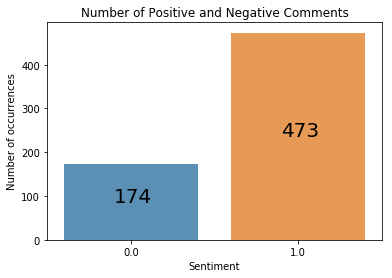

In [9]:
# Most of the comments are positive comment.
# Convert score into positive and negative comment.

full_eng2["sentiment"] = np.where(full_eng["1"] <= 3, 0,"")
full_eng2["sentiment"] = np.where(full_eng["1"] >= 4, 1,full_eng2["sentiment"])
full_eng2["sentiment"] = full_eng2["sentiment"].astype('float64')
full_eng2["sentiment"].value_counts()

count = full_eng2["sentiment"].value_counts()
sns.barplot(count.index, count.values, alpha=0.8)
plt.title('Number of Positive and Negative Comments')
plt.ylabel('Number of occurrences')
plt.xlabel('Sentiment')
for i in range(len(count.values)):
    plt.text(x = count.index[i]-0.1, y=count.values[i]/2, s=count.values[i], size = 20)
plt.show()

Convert the score into 1 and 0. 1 is classified as positive sentiment (score more than 3) and 0 is classified as negative sentiment (score less than or equal to 3)

#### Tokenization

In [10]:
# Token the words to convert into lower case and remove words that have less than 2 characters.

full_eng22 = full_eng2.iloc[:,0].values
full_eng22_list = full_eng22.tolist()
df_full_eng22 = pd.DataFrame(full_eng22)

word = []
for i in range(len(full_eng2)):
    blob = TextBlob(full_eng22[i])
    word.append(blob.lower().words) #convert into lower case

word2 = []
for i in range(len(word)):
    sentence = []
    for j in range(len(word[i])):
        if len(word[i][j]) > 2:
            sentence.append(word[i][j]) #collect only word that has more than 2 characters (remove acronyms, emoticons and conjunctions)
    word2.append(sentence)

#### Remove Stopwords

In [11]:
stopWords2 = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now", "'re"]

word3 = []
for i in range(len(word2)):
    x = []
    for j in range(len(word2[i])):
        if word2[i][j] not in stopWords2: 
            x.append(word2[i][j])
    word3.append(x)
    
#Lemmatize
def lemmatize_with_postag(sentence):
    sent = TextBlob(sentence)
    tag_dict = {"J": 'a', 
                "N": 'n', 
                "V": 'v', 
                "R": 'r'}
    words_and_tags = [(w, tag_dict.get(pos[0], 'n')) for w, pos in sent.tags]    
    lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]
    return " ".join(lemmatized_list)

new_sen = []   
for i in range(len(word3)):
    l = []
    for k in range(len(word3[i])):
        l.append(word3[i][k].singularize())
        x2 = " ".join(l)
    new_sen.append(x2)

new_sen2 = []
[new_sen2.append(lemmatize_with_postag(new_sen[i])) for i in range(len(new_sen))]
new_sen2[:3]

['use lasik good year since effect price also good cut may look scary really time not hurt drop anesthetic dissection',
 'maintain many year since age bachelor degree sleep midst arthropod recover could live normal life particular premium clinic not wait long time convenient fast every step pay dispense treatment fee not expensive compare many private service good want everyone come',
 '2nd floor phra thep build place look modern pressure measure room person temple think not nurse wear purple dres like scold person come temple speak stiffly person come measure pressure spite nurse put nurse gown say want improve come doctor surgery department tawut tell surgery say surgery heal time shock surgery fog go not really tell distance roi-laem meeting nurse nuek kyu not care repeat say correct say conclusion seem good wait see surgery']

#### Inflection/Stemming

In [12]:
# Convert the word into singular

new_sen3 = []
for i in range(len(new_sen2)):
    text = TextBlob(new_sen2[i])
    a_sentence = []
    a = text.words
    for k in range(len(a)):
        a_sentence.append(a[k].singularize())
        x2 = " ".join(a_sentence)
    new_sen3.append(x2)

new_sen3[:3]

['use lasik good year since effect price also good cut may look scary really time not hurt drop anesthetic dissection',
 'maintain many year since age bachelor degree sleep midst arthropod recover could live normal life particular premium clinic not wait long time convenient fast every step pay dispense treatment fee not expensive compare many private service good want everyone come',
 '2nd floor phra thep build place look modern pressure measure room person temple think not nurse wear purple dre like scold person come temple speak stiffly person come measure pressure spite nurse put nurse gown say want improve come doctor surgery department tawut tell surgery say surgery heal time shock surgery fog go not really tell distance roi-laem meeting nurse nuek kyu not care repeat say correct say conclusion seem good wait see surgery']

#### Remove numbers

In [13]:
new_sen4 = []
for i in range(len(new_sen3)):
    new_sen4.append(re.sub(r'\d+', "", new_sen3[i]))

new_sen5 = []
for i in range(len(new_sen4)):
    word = []
    blob = TextBlob(new_sen4[i])
    word.append(blob.words)
    for i in range(len(word)):
        sentence = []
        for j in range(len(word[i])):
            if len(word[i][j]) > 2:
                sentence.append(word[i][j]) #collect only word that has more than 3 characters (remove acronyms, emoticons and conjunctions)   
    new_sen5.append(sentence)

new_sen6 = []
for i in range(len(new_sen5)):
    sen = []
    for j in range(len(new_sen5[i])):
        if new_sen5[i][j] == "n't":
            sen.append('not')
        else:
            sen.append(new_sen5[i][j])
    new_sen6.append(sen)

new_sen7 = []
for i in range(len(new_sen6)):
    sentence = []
    for k in new_sen6[i]:
        sentence.append(k)
        x2 = " ".join(sentence)
    new_sen7.append(x2)

In [14]:
total_word = [new_sen6[i][j] for i in range(len(new_sen6)) for j in range(len(new_sen6[i]))]
print('total number of words: ', len(total_word))

total number of words:  14329


In [15]:
df_all = full_eng2.copy()
df_new_sen7 = pd.DataFrame(new_sen7)
df_all['final_sen'] = df_new_sen7
df_all.head()

,0,sentiment,final_sen
0,"I used to go to LASIK here. Very good. Now, it has been 2 years since it has no effect. And the price is also good. The cut may look scary. But when it was really time to do it, it did not hurt. Because there was a drop of anesthetic before dissection",1.0,use lasik good year since effect price also good cut may look scary really time not hurt drop anesthetic dissection
1,"Maintained for many years since the age of 14 Will now have a bachelor's degree From sleeping in the midst of the arthropod until he recovered, he could live a normal life. In particular, premium clinics do not have to wait for a long time. There are convenient, fast, every step from paying to dispensing. The treatment fee is not too expensive when compared to many private services that are very good. Want everyone to come here",1.0,maintain many year since age bachelor degree sleep midst arthropod recover could live normal life particular premium clinic not wait long time convenient fast every step pay dispense treatment fee not expensive compare many private service good want everyone come
2,"At the 2nd floor of Phra Thep building, the place looks modern. But at the pressure measuring room There are people at the temple (thinking that it is not a nurse because wearing a purple dress) likes to scold people who come to the temple. Speak stiffly to people who come to measure pressure. In spite of the other nurses who put on a nursing gown, said because Want to improve Come to the doctor at the surgery department Dr. Tawut, then told to have surgery. Just saying that he had to surgery to be healed at that time, he was shocked about the surgery. And the fog went, not really telling what was the distance (Roi-Laem) and then meeting The nurse at Nuek Kyu does not care when we repeat what he says is correct. Just saying that In conclusion, it seems to be good, but waiting to see the surgery before",0.0,floor phra thep build place look modern pressure measure room person temple think not nurse wear purple dre like scold person come temple speak stiffly person come measure pressure spite nurse put nurse gown say want improve come doctor surgery department tawut tell surgery say surgery heal time shock surgery fog not really tell distance roi-laem meeting nurse nuek kyu not care repeat say correct say conclusion seem good wait see surgery
3,"Its a public hospital so service is bad (nurses are completely unfriendly and doctors have god complex plus horrifying bed side manner) but they will keep you alive (nothing to do with quality of life) with decent drug collection. Young doctors are generally very friendly but they are busy all the time due to the amount of patients (like canned tuna) so do not expect them to spend too much time diagnosing you. You have to come early in the morning to ensure you are in queue and the wait 1-2 (bad days) hours behind schedule to get to see the doctor for < 15 min or less (all together door to door 8-9hrs). Additionally you can call all the 8 numbers on the websites from normal clinic to Premium and wait 15 minutes on each number just for them to hang up on you or divert you elsewhere then hang up on you..... Worst are the guys doing the schedule because they are very consistent in demonstrating the inability to manage schedules (or not) because you will ""always"" have to wait 1-2 hours ""after"" your appointment schedule to see the doctor but they also cant tell you that so you cant go anywhere and have to hang around the front door. In the better days you will get to sit inside the doctor's room to wait because the doctor is no where to be found and nobody will know when he/she will come back. If you ask the nurse they will give you the ""i dont know and I couldnt care less"" look and turn away in annoyance. But yes, they have great ability (the doctors definitely know what they are doing) to use ur tax fund to keep you alive, two stars for that!! Updated review for ER: The best ER u can probably find in 

In [16]:
df_total_word = pd.DataFrame(total_word)
df_unique_word = df_total_word.drop_duplicates()
unique_word_count = df_unique_word.count()[0]
print('Total number of unique words: ', unique_word_count)

Total number of unique words:  2457


#### Balance Data

<p>
    The data here is not balanced. Therefore, we will use all negative sentiment (n=158) and randomly selected 178 positive sentiments to generate balanced class dataset.
</p>

In [17]:
# Create the balanced data by random sampling the positive comment while use are the negative comment for model development.

data0 = df_all[df_all["sentiment"] == 0]
data1 = df_all[df_all["sentiment"] == 1]
sample = data1.sample(n=len(data0), random_state = 28)
balanced_data = data0.append(sample)
balanced_data["sentiment"].value_counts()
balanced_data['hospital'] = full_eng['3']
balanced_data['Thai'] = full_eng['0']
balanced_data.rename(columns={0:'original_sen'}, inplace=True)

# Rearrange columns position
cols = balanced_data.columns.tolist()
cols = ['Thai', 'original_sen', 'final_sen', 'sentiment',  'hospital' ]
balanced_data = balanced_data[cols]

print('Number of samples: ', len(balanced_data))

Number of samples:  348


In [18]:
balanced_data["sentiment"].value_counts()

1.0    174
0.0    174
Name: sentiment, dtype: int64

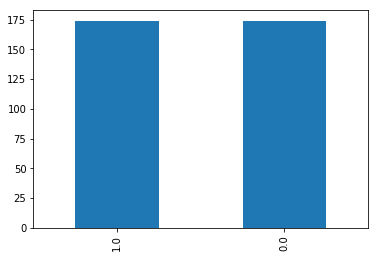

In [19]:
balanced_data["sentiment"].value_counts().plot.bar()

In [20]:
balanced_data.head()

,Thai,original_sen,final_sen,sentiment,hospital
2,ที่ตึกพระเทพชั้น 2 สถานที่เครื่องมือดูทันสมัย \rแต่ที่ห้องวัดความดัน มีคนที่วัด(คิดว่าไม่ใช่พยาบาลเพราะใส่ชุดสีม่วง) ชอบดุคนที่มาวัด พูดเสียงแข็งใส่คนที่มาวัดความดัน ทั้งๆที่พยาบาลอีกคนที่ใส่ชุดพยาบาลพูดเพราะ อยากให้ปรับปรุง \r มาหาหมอที่แผนกศัลยกรรม อาจารย์หมอตรวตแล้วบอกต้องผ่าตัด บอกแค่ว่าต้องผ่าตัดถึงจะหายตอนนั้นช็อคเรื่องผ่าตัดอยู่เลยไม่ได้ถามอะไรเลย แล้วหมอกก็ไปเลยไม่ได้บอกว่าจริงๆเป็นอะไร ระยะไหน (ริดสีดวง) แล้วก็นัดวันผ่า พยาบาลที่นัดคิวก็ไม่สนเวลาเราทวนสิ่งที่บอกมาว่าถูกต้องไหม บอกแค่ว่าตามนั้นแหละ สรุปแล้วเหมือนจะดีแต่รอดูช่วงผ่าตัดก่อน,"At the 2nd floor of Phra Thep building, the place looks modern. But at the pressure measuring room There are people at the temple (thinking that it is not a nurse because wearing a purple dress) likes to scold people who come to the temple. Speak stiffly to people who come to measure pressure. In spite of the other nurses who put on a nursing gown, said because Want to improve Come to the doctor at the surgery department Dr. Tawut, then told to have surgery. Just saying that he had to surgery to be healed at that time, he was shocked about the surgery. And the fog went, not really telling what was the distance (Roi-Laem) and then meeting The nurse at Nuek Kyu does not care when we repeat what he says is correct. Just saying that In conclusion, it seems to be good, but waiting to see the surgery before",floor phra thep build place look modern pressure measure room person temple think not nurse wear purple dre like scold person come temple speak stiffly person come measure pressure spite nurse put nurse gown say want improve come doctor surgery department tawut tell surgery say surgery heal time shock surgery fog not really tell distance roi-laem meeting nurse nuek kyu not care repeat say correct say conclusion seem good wait see surgery,0.0,rama
20,ดีทุกอย่าง ติดตรงค่าบริการ แยกบิลแปลกๆ ซ้ำซ้อน จนต้องเดินไปถาม บอกมาเเค่ว่าหมอสั่ง เฮ้อ,"Well, everything is straight, the bill is strange, redundant, so have to walk to ask. Told me that the doctor ordered hey",well everything straight bill strange redundant walk ask tell doctor order hey,0.0,rama
35,ไปตรวจตามนัด แล้วมีอาการใจสั่น หมอเลยให้ไปตรวจคลื่นไฟฟ้าหัวใจ ห้องตรวจอยู่ชั้น 2 แต่กลับต้องไปจ่ายเงินค่าทำที่การเงินชั้น 1 ก่อน จากนั้นกลับมาชั้น 2 พยาบาลก็ค่อยบอกว่าต้องขึ้นไปทำชั้น 3 ไม่เข้าใจว่าทำไม่ไม่ทำให้เรียบร้อย ตรวจให้เสร็จแล้วค่อยไปจ่ายเงินทีเดียว ถ้าเป็นโรคหัวใจจริงคงหัวใจวายตายไปแล้ว,"Went to check on the appointment and had a palpitation The doctor then went to check the ECG. The examination room is on the second floor, but has to go to pay for the money at the first floor. First, then back to the 2nd floor. Complete the examination and pay for it. If the heart disease is true, the heart attack is dead.",check appointment palpitation doctor check ecg examination room second floor pay money first floor first back floor complete examination pay heart disease true heart attack dead,0.0,rama
47,แผนก #หนวยสิทธิประโยชน์ผู้รับบริการ ชั้น1 ตรงประตูทางเข้า แยกตึกชัย ควรที่จะปรับปรุง เรื้องบัตรคิว นะครับ อย่าก จะแนะนำ ให้ นำบัตรคิว มาวางก่อน ได้มัย ผู้รับบริการจะได้ ไม่ต้องไปต่อแถวรอครับ บางคน ก็แทรกแถว บางคนก็แซงคิว อย่ากให้เห็นใจคนที่เจารอ อะคับ บางทีบัตรคิว ก็เปลียนตำแหนงวาง บอกเลย แย่มาก . บอกเลยเป็นอย่างนีมาหลายปีละ ผมมาก่อน ตี4 ทึกครั้งเห็นทุกครั้ง ครับ แค่อย่ากแนะนำ,"Department # 1, Beneficiaries, 1st Floor, at the entrance to the Chai Building, should be improved. Reduces the queue card. Do not recommend to put the queue card before placing the service. Do not have to go in line, wait for some people to insert rows, some people overtake the queue. Do not be sympathetic to those who wait. Sometimes, the queue card changes. The location is very bad. Tell me, like this, for many years, I come before 4 times. Every time I see it. recommend",department beneficiary floor entrance chai building improve reduce queue card not recommend put queue card place service not line wait person insert 

In [21]:
# Find the number of unique words in the data

index_list = balanced_data.index.values #get a index value

data_sen = []
for i in balanced_data['final_sen'][index_list]:
    data_sen.append(i.split())

total_word2 = [data_sen[i][j] for i in range(len(data_sen)) for j in range(len(data_sen[i]))]
unique_word2 = set(total_word2) #remove word duplicate
unique_word2 = list(unique_word2)
unique_word2_count = len(unique_word2)

print('Total number of unique word in balanced data: ',unique_word2_count)
print('Words example: ', unique_word2[:10])

Total number of unique word in balanced data:  1797
Words example:  ['moderate', 'pres', 'rubbish', 'consultation', 'viru', 'confirm', 'xray', 'fine', 'pill', 'hmy']


### <i>Build Deep Learning Model

<p>
    There are many type of deep learning model. In this assignment, rather than using feed forward neural network, long-short term memory (LSTM), a type of recurrent neural network (RNN) will be used. Because feed forward neural networks has that assumption that all inputs are independent of each other. However, our data which is text data which is a type of sequential data which ordering of the input matter for prediction. RNN solves this problem as it uses the previous learned output to predict the next language. In some case, traditional RNN is prone to vanishing gradient during backpropagation therefore LSTM is used to help in storing only relavent output.
</p>
<p>
    Moreover, transfer learning is very popular that help to increase the speed of training and increase model accuracy. This method uses word embedding that is based on distributional hypothesis that some words are used in the same context which might be sematically similar. The transfer learning that is used in the assignment is Global Vector (GloVe) provided by Stanford. GloVe is a pretrained word vectors that are trained using 2010 Wikipedia dump (1 billion tokens), 2014 Wikipedia dump (1.6 billion tokens), Gigaword 5 (4.3 billion tokens) and web data from Common Crawl (42 billion tokens)
</p>
<p>
    In this assignment, the label is in scoring to decide whether it is negative or positive comments. The label data cannot be both positive and negative comment at the same time (as we don't have that kind of label). Softmax activation function assumes that the output classes is dependent on the other output class (positive and negative) while sigmoid assume independent and suitable for binary classification. However, softmax activation function can be used in binary classification as well which result the same as activation function. This means either we use softmax or sigmoid as activation function is the same. T In this assignment I will use sigmoid as an activation fucntion.
</p>


[Reference](https://nlp.stanford.edu/pubs/glove.pdf)

In [22]:
# Average length of the sentence from all comments
num_sentence = [len(w) for w in new_sen7]
max_length =  max([len(w) for w in new_sen7])
avg_length = round(statistics.mean(num_sentence),0)


# Tokenize the word using keras library
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(balanced_data['final_sen'].values)
vocab_size = len(tokenizer.word_index)

print('Longest setence has', max_length, 'words')
print('Setence has an average of', avg_length, 'words')

Longest setence has 2049 words
Setence has an average of 146.0 words


#### Train Test

In [23]:
'''
We want to separate train and test set before converting text to sequence because we want to save the comment of the data.
If perform text to sequence before split train and test set, we cannot evaluate which sentence cause the prediction error and the index will be remove
'''

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(balanced_data, 
                                                              balanced_data['sentiment'], 
                                                              test_size=0.2,
                                                              random_state=28,
                                                              stratify=balanced_data['sentiment'])


X_train, X_validate, y_train, y_validate = train_test_split(X_train_data, 
                                                              y_train_data, 
                                                              test_size=0.11,
                                                              random_state=28)

# dummy labeled is used for model that use softmax as an activation function
y_train_dummy = pd.get_dummies(y_train).values
y_test_dummy = pd.get_dummies(y_test_data).values
y_validate_dummy = pd.get_dummies(y_validate).values

In [24]:
# Perform text to sequence
'''
This is text to sequence of all the comment in the balanced data.
It will be used in the input of the model
'''
X = tokenizer.texts_to_sequences(balanced_data['final_sen'].values) #convert text to vector sequence

# The maximum length of word in a comment is about 2000 words and avereage of about 150 words
# Therefore, input length of sequence I use should be around 500 words
max_len = 500
X = pad_sequences(X, maxlen=max_len) #padding to get same length of sequence
X_train = tokenizer.texts_to_sequences(X_train['final_sen'].values)
X_test = tokenizer.texts_to_sequences(X_test_data['final_sen'].values)
X_validate = tokenizer.texts_to_sequences(X_validate['final_sen'].values)


X_train = pad_sequences(X_train, max_len)
X_test = pad_sequences(X_test, max_len)
X_validate = pad_sequences(X_validate, max_len)

In [25]:
# y2 = pd.get_dummies(balanced_data['sentiment']).values #use when to use only keras model no grid search
# y = balanced_data['sentiment'].values #use when use gridsearch

# def train_test(X, y):
#     X_train, X_test, y_train, y_test = train_test_split(
#         X, y, test_size=0.2, random_state=28, stratify=y)
    
#     X_train, X_test, y_train_dummy, y_test_dummy = train_test_split(
#         X, y2, test_size=0.2, random_state=28, stratify=y)

#     return X_train, X_test, y_train, y_test, y_train_dummy, y_test_dummy

In [26]:
# X_train, X_test, y_train, y_test, y_train_dummy, y_test_dummy = train_test(X, y)

### Create model

### LSTM (Long-Short term memory)

We will tune the hyperparameters that give the best accuracy. 
These hyperparameters are batch size, number of hidden layers, number of neurons in each layer, learning rate,
drop out and etc. Some hyperparameter will use default value from keras.

In [27]:
# Initialize Parameters

embed_dim = 100
lstm_out = 1
dropout_rate = 0.1
dropout = 0.1
recurrent_dropout = 0.1

In [28]:
def create_model():
    model = Sequential()
    model.add(Embedding(unique_word2_count+1, embed_dim, input_length = max_len))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_out, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True))
    model.add(LSTM(lstm_out, dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return model

#### Model Tuning

- Epochs

Epochs will be tuned later together with gridsearch to find the optimal weight and other hyperparameters.

- Batch Size, Nodes, dropout_rate, dropout, recurrent_dropout

In [29]:
def create_model_sigmoid(lstm_out=1, lstm_out2=1, dropout_rate=0.1, dropout=0.1, recurrent_dropout=0.1, hidden=1):
    model = Sequential()
    model.add(Embedding(unique_word2_count+1, embed_dim, input_length = max_len))
    for layer in range(hidden):
        model.add(LSTM(lstm_out, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True))
    model.add(LSTM(lstm_out2, dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return model

In [31]:
def create_model_softmax(lstm_out=1, lstm_out2=1, dropout_rate=0.1, dropout=0.1, recurrent_dropout=0.1, hidden=1):
    model = Sequential()
    model.add(Embedding(unique_word2_count+1, embed_dim, input_length = max_len))
    for layer in range(hidden):
        model.add(LSTM(lstm_out, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True))
    model.add(LSTM(lstm_out2, dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dropout(dropout_rate))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return model

In [34]:
def plot(history):
    acc= history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    fig = plt.figure()
    plt.plot(epochs, acc, 'b--', label='Training acc')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_acc, 'r--', label='Validation acc')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation accuracy')
    plt.gca().set_ylim(0,1)
    plt.legend()
    plt.show()
    return fig

In [33]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_epoch_end(self, batch, logs={}):
        with open('logs.txt', 'a') as f:
            stats = []
            stats.append(str(batch))
            stats.append('Optimizer,' + self.model.optimizer.__class__.__name__)
            stats.append('Batch_size,' + str(self.params['batch_size']))
            stats.append('accuracy,'+str(logs.get('acc')))
            stats.append('val_loss,'+str(logs.get()))
            f.write(','.join(stats)+'\n')

#### Sigmoid

In [44]:
'''
We tune the model using random search as grid search will take a long time to tune. 
Also, the data here is small in which using random search to tune the model is appropriate.
'''

np.random.seed(28)
set_random_seed(28)

start=time()

model_sigmoid = KerasClassifier(build_fn=create_model_sigmoid, verbose=1, epochs=100)

lstm_out = [1,2,8,16,32]
lstm_out2 = [1,2,8,16,32]
dropout_rate = [0.1]
dropout = [0.1]
recurrent_dropout = [0.1]
batch_size = [16, 32, 64]
hidden = [1,2,3]

param_grid = dict(lstm_out=lstm_out,
                  lstm_out2=lstm_out2,
                  hidden=hidden,
                  dropout_rate=dropout_rate, 
                  dropout=dropout, 
                  recurrent_dropout=recurrent_dropout,
                  batch_size=batch_size)

grid = RandomizedSearchCV(estimator=model_sigmoid, 
                          param_distributions=param_grid,
                          scoring="accuracy",
                          cv=ShuffleSplit(test_size=0.10, random_state=28, n_splits=1),
                          n_jobs=-1)


In [177]:
np.random.seed(28)
set_random_seed(28)

# history = LossHistory()
grid_result = grid.fit(X_train, y_train ,
                       callbacks=[EarlyStopping(
                           patience=10, 
                           monitor='val_loss', 
                           min_delta=0.0001,
                           verbose=1)],                        
                       validation_data = [X_validate,y_validate]) 

print("total time:",time()-start)


print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Train on 247 samples, validate on 31 samples
Epoch 1/100
247/247 [==============================] - 8s 31ms/step - loss: 0.6929 - acc: 0.4899 - val_loss: 0.6865 - val_acc: 0.5806
Epoch 2/100
247/247 [==============================] - 5s 20ms/step - loss: 0.6767 - acc: 0.6802 - val_loss: 0.6883 - val_acc: 0.5484
Epoch 3/100
247/247 [==============================] - 5s 20ms/step - loss: 0.6649 - acc: 0.6802 - val_loss: 0.6846 - val_acc: 0.5484
Epoch 4/100
247/247 [==============================] - 5s 20ms/step - loss: 0.6502 - acc: 0.6964 - val_loss: 0.6812 - val_acc: 0.5484
Epoch 5/100
247/247 [==============================] - 5s 20ms/step - loss: 0.6282 - acc: 0.7409 - val_loss: 0.6734 - val_acc: 0.5484
Epoch 6/100
247/247 [==============================] - 5s 21ms/step - loss: 0.6143 - acc: 0.7611 - val_loss: 0.6592 - val_acc: 0.6129
Epoch 7/100
247/247 [==============================] - 5s 21ms/step - loss: 0.5728 - acc: 0.8178 - val_loss: 0.6380 - val_acc: 0.6452
Epoch 8/100
247/2

In [178]:
joblib.dump(grid_result.best_estimator_.model, 'models/sigmoid_grid_model.pkl')
joblib.dump(grid_result.best_params_, 'models/sigmoid_grid_best_params.pkl')
joblib.dump(grid_result, 'models/sigmoid_grid.pkl')

['models/sigmoid_grid.pkl']

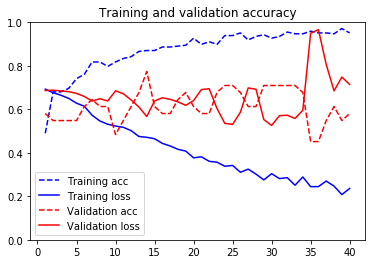

In [179]:
fig = plot(grid_result.best_estimator_.model.history)

In [180]:
grid_result.best_estimator_.model.history.history

{'val_loss': [0.686481237411499,
  0.6882679462432861,
  0.6845549941062927,
  0.6811620593070984,
  0.673394501209259,
  0.6592001914978027,
  0.6379721760749817,
  0.6487269401550293,
  0.6385308504104614,
  0.6850618124008179,
  0.6719056367874146,
  0.6431394815444946,
  0.6107615232467651,
  0.5669572353363037,
  0.6383500695228577,
  0.6531416177749634,
  0.6459562182426453,
  0.634432852268219,
  0.6184391975402832,
  0.6400326490402222,
  0.6908812522888184,
  0.6945948004722595,
  0.6041725277900696,
  0.5354185700416565,
  0.530764639377594,
  0.5868662595748901,
  0.6984093189239502,
  0.6923653483390808,
  0.5529705286026001,
  0.525897741317749,
  0.5706478953361511,
  0.5729803442955017,
  0.5580941438674927,
  0.5958502888679504,
  0.9505554437637329,
  0.9664499163627625,
  0.805797815322876,
  0.6849286556243896,
  0.7486000061035156,
  0.7143785953521729],
 'val_acc': [0.5806451439857483,
  0.5483871102333069,
  0.5483871102333069,
  0.5483871102333069,
  0.5483871102

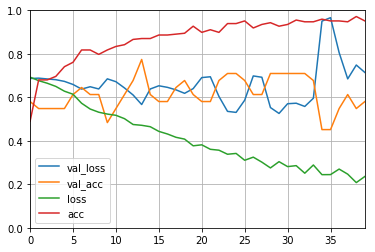

In [181]:
pd.DataFrame(grid_result.best_estimator_.model.history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [182]:
grid_result.best_estimator_.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 100)          179800    
_________________________________________________________________
lstm_3 (LSTM)                (None, 500, 8)            3488      
_________________________________________________________________
lstm_4 (LSTM)                (None, 500, 8)            544       
_________________________________________________________________
lstm_5 (LSTM)                (None, 2)                 88        
_________________________________________________________________
dropout_2 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 183,923
Trainable params: 183,923
Non-trainable params: 0
_________________________________________________________________


In [184]:
grid_result.best_params_

{'recurrent_dropout': 0.1,
 'lstm_out2': 2,
 'lstm_out': 8,
 'hidden': 2,
 'dropout_rate': 0.1,
 'dropout': 0.1,
 'batch_size': 32}

#### Softmax

In [32]:
'''
We tune the model using random search as grid search will take a long time to tune. 
Also, the data here is small in which using random search to tune the model is appropriate.
'''
np.random.seed(28)
set_random_seed(28)

start=time()

model_softmax = KerasClassifier(build_fn=create_model_softmax, verbose=1, epochs=100)

lstm_out = [1,2,8,16,32]
lstm_out2 = [1,2,8,16,32]
dropout_rate = [0.1]
dropout = [0.1]
recurrent_dropout = [0.1]
batch_size = [16, 32, 64]
hidden = [1,2,3]

param_grid = dict(lstm_out=lstm_out,
                  lstm_out2=lstm_out2,
                  hidden=hidden,
                  dropout_rate=dropout_rate, 
                  dropout=dropout, 
                  recurrent_dropout=recurrent_dropout,
                  batch_size=batch_size)

grid = RandomizedSearchCV(estimator=model_softmax, 
                          param_distributions=param_grid,
                          scoring="accuracy",
                          cv=ShuffleSplit(test_size=0.10, random_state=28, n_splits=1),
                         n_jobs=-1)


In [33]:
np.random.seed(28)
set_random_seed(28)

history = LossHistory()
grid_result = grid.fit(X_train, y_train,
                       callbacks=[EarlyStopping(
                           patience=10, 
                           monitor='val_loss', 
                           min_delta=0.0001,
                           verbose=1)],                        
                       validation_data = [X_validate,y_validate_dummy])

print("total time:",time()-start)


print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

W0806 16:08:19.381200 23472 deprecation_wrapper.py:119] From D:\Users\Nugliar\Anaconda3\envs\keras_cpu\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0806 16:08:19.383195 23472 deprecation_wrapper.py:119] From D:\Users\Nugliar\Anaconda3\envs\keras_cpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0806 16:08:19.385189 23472 deprecation_wrapper.py:119] From D:\Users\Nugliar\Anaconda3\envs\keras_cpu\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0806 16:08:19.569696 23472 deprecation_wrapper.py:119] From D:\Users\Nugliar\Anaconda3\envs\keras_cpu\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_w

Train on 247 samples, validate on 31 samples
Epoch 1/100
247/247 [==============================] - 13s 51ms/step - loss: 0.6933 - acc: 0.4980 - val_loss: 0.6925 - val_acc: 0.5484
Epoch 2/100
247/247 [==============================] - 9s 37ms/step - loss: 0.6861 - acc: 0.6680 - val_loss: 0.7032 - val_acc: 0.4839
Epoch 3/100
247/247 [==============================] - 9s 36ms/step - loss: 0.6707 - acc: 0.6761 - val_loss: 0.7175 - val_acc: 0.5484
Epoch 4/100
247/247 [==============================] - 9s 36ms/step - loss: 0.6387 - acc: 0.6802 - val_loss: 0.6295 - val_acc: 0.6452
Epoch 5/100
247/247 [==============================] - 9s 36ms/step - loss: 0.5320 - acc: 0.7692 - val_loss: 0.7188 - val_acc: 0.5806
Epoch 6/100
247/247 [==============================] - 9s 35ms/step - loss: 0.4287 - acc: 0.7814 - val_loss: 0.7404 - val_acc: 0.5161
Epoch 7/100
247/247 [==============================] - 9s 34ms/step - loss: 0.3785 - acc: 0.8340 - val_loss: 0.6267 - val_acc: 0.5806
Epoch 8/100
247/

In [34]:
joblib.dump(grid_result.best_estimator_.model, 'models/softmax_grid_model.pkl')
joblib.dump(grid_result.best_params_, 'models/softmax_grid_best_params.pkl')
joblib.dump(grid_result, 'models/softmax_grid.pkl')

['models/softmax_grid.pkl']

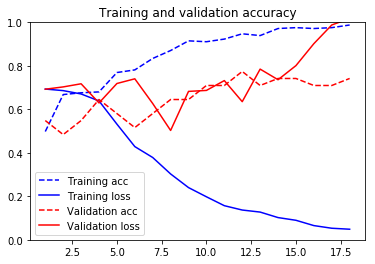

In [38]:
fig = plot(grid_result.best_estimator_.model.history)

In [40]:
print("Optimal architecture from random search: ")
grid_result.best_estimator_.model.summary()

Optimal architecture from random search: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 100)          179800    
_________________________________________________________________
lstm_1 (LSTM)                (None, 500, 32)           17024     
_________________________________________________________________
lstm_2 (LSTM)                (None, 500, 32)           8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 500, 32)           8320      
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None

In [41]:
grid_result.best_params_

{'recurrent_dropout': 0.1,
 'lstm_out2': 32,
 'lstm_out': 32,
 'hidden': 3,
 'dropout_rate': 0.1,
 'dropout': 0.1,
 'batch_size': 32}

In [30]:
grid_sigmoid = joblib.load('models/sigmoid_grid_best_params.pkl')
grid_softmax = joblib.load('models/softmax_grid_best_params.pkl')

### Model with tuned parameters

#### Perform longer epochs

According to the figures of accuracy and loss of train and validation sets from both sigmoid and softmax, it shows that the accuracy and loss of getting better with epoch. Even there are times validation loss shoot up a lot, but this might due to error during the batch training and it might not find the least validation loss yet. Therefore, increase the number of epoch might find the best validation accuracy and least validation loss. Just be aware that too much training could lead to overfitting.

In [31]:
'''
Using Sigmoid activation shows higher accuray that Softmax activation function. Therefore, we will use sigmoid as an activation function and other tuned parameters.
'''

def create_model_sigmoid(X_train, y_train, path, epochs):
    '''
    Generate LSTM model according to the hyperparameter stated aboved.
    Parameters-
    X_train: train data
    y_train: labeled data
    '''

    # Parameters
    embed_dim = 100
    lstm_out = grid_sigmoid['lstm_out']
    lstm_out2 = grid_sigmoid['lstm_out2']
    dropout_rate = grid_sigmoid['dropout_rate']
    dropout = grid_sigmoid['dropout']
    recurrent_dropout = grid_sigmoid['recurrent_dropout']
    batch_size = grid_sigmoid['batch_size']
    hidden = grid_sigmoid['hidden']
    epochs = epochs
    
    set_random_seed(28)
    np.random.seed(28)

    start=time()
    model = Sequential()
    model.add(Embedding(unique_word2_count+1, embed_dim, input_length = max_len))
    for layer in range(hidden):
        model.add(LSTM(lstm_out, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True))
    model.add(LSTM(lstm_out2, dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    #Save the weight of the best model
    filepath=path
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
    callbacks_list = [checkpoint]

    history = model.fit(X_train,
                        y_train, 
                        epochs = epochs, 
                        batch_size=batch_size, 
                        validation_data = [X_validate,y_validate], 
                        callbacks=callbacks_list, 
                        verbose = 1)
    print("total time:",time()-start)
    
    return model, history

In [32]:
model_sigmoid1, history_sigmoid1 = create_model_sigmoid(X_train, y_train, "models/sigmoid.weights.best.h5", epochs=100)

W0808 16:25:06.869805 22464 deprecation_wrapper.py:119] From D:\Users\Nugliar\Anaconda3\envs\keras_cpu\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0808 16:25:06.870803 22464 deprecation_wrapper.py:119] From D:\Users\Nugliar\Anaconda3\envs\keras_cpu\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0808 16:25:06.939619 22464 deprecation_wrapper.py:119] From D:\Users\Nugliar\Anaconda3\envs\keras_cpu\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0808 16:25:07.348534 22464 deprecation_wrapper.py:119] From D:\Users\Nugliar\Anaconda3\envs\keras_cpu\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_w

Train on 247 samples, validate on 31 samples
Epoch 1/100
247/247 [==============================] - 7s 29ms/step - loss: 0.6931 - acc: 0.4818 - val_loss: 0.6939 - val_acc: 0.3548

Epoch 00001: val_loss improved from inf to 0.69388, saving model to models/sigmoid.weights.best.h5
Epoch 2/100
247/247 [==============================] - 4s 18ms/step - loss: 0.6919 - acc: 0.5425 - val_loss: 0.6932 - val_acc: 0.3871

Epoch 00002: val_loss improved from 0.69388 to 0.69324, saving model to models/sigmoid.weights.best.h5
Epoch 3/100
247/247 [==============================] - 4s 18ms/step - loss: 0.6907 - acc: 0.5749 - val_loss: 0.6931 - val_acc: 0.3871

Epoch 00003: val_loss improved from 0.69324 to 0.69314, saving model to models/sigmoid.weights.best.h5
Epoch 4/100
247/247 [==============================] - 4s 17ms/step - loss: 0.6893 - acc: 0.6235 - val_loss: 0.6922 - val_acc: 0.4516

Epoch 00004: val_loss improved from 0.69314 to 0.69224, saving model to models/sigmoid.weights.best.h5
Epoch 5

247/247 [==============================] - 4s 17ms/step - loss: 0.2617 - acc: 0.8543 - val_loss: 0.6529 - val_acc: 0.7097

Epoch 00083: val_loss did not improve from 0.59229
Epoch 84/100
247/247 [==============================] - 4s 17ms/step - loss: 0.2755 - acc: 0.8623 - val_loss: 0.6658 - val_acc: 0.7097

Epoch 00084: val_loss did not improve from 0.59229
Epoch 85/100
247/247 [==============================] - 4s 16ms/step - loss: 0.2495 - acc: 0.8745 - val_loss: 0.6908 - val_acc: 0.6774

Epoch 00085: val_loss did not improve from 0.59229
Epoch 86/100
247/247 [==============================] - 4s 16ms/step - loss: 0.2781 - acc: 0.8583 - val_loss: 0.6986 - val_acc: 0.6774

Epoch 00086: val_loss did not improve from 0.59229
Epoch 87/100
247/247 [==============================] - 4s 17ms/step - loss: 0.2548 - acc: 0.8745 - val_loss: 0.6827 - val_acc: 0.7097

Epoch 00087: val_loss did not improve from 0.59229
Epoch 88/100
247/247 [==============================] - 4s 17ms/step - loss: 0

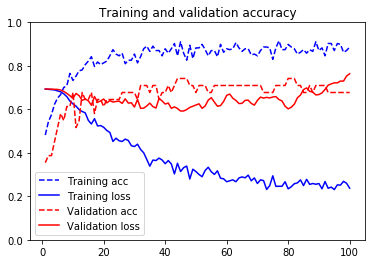

In [35]:
fig_LSTM_sigmoid = plot(history_sigmoid1)

The result shows that the loss decrease gradually and accuracy increase for training set. However, the accuracy of the validation set is decreasing and loss increase dramatically after 20 epochs. This suggest that the model might be overfit.

The weight at around 60 epoch give the least loss which is saved and will be used later.

In [46]:
'''
We want want to see how softmax perform when compare to sigmoid as well.
'''

def create_model_softmax(X_train, y_train, path, epochs):
    '''
    Generate LSTM model according to the hyperparameter stated aboved.
    Parameters-
    X_train: train data
    y_train: labeled data
    '''
    # Parameters
    embed_dim = 100
    lstm_out = grid_softmax['lstm_out']
    lstm_out2 = grid_softmax['lstm_out2']
    dropout_rate = grid_softmax['dropout_rate']
    dropout = grid_softmax['dropout']
    recurrent_dropout = grid_softmax['recurrent_dropout']
    batch_size = grid_softmax['batch_size']
    hidden = grid_softmax['hidden']
    epochs = epochs
    
    
    np.random.seed(28)
    set_random_seed(28)
    
    start=time()
    model = Sequential()
    model.add(Embedding(unique_word2_count+1, embed_dim, input_length = max_len))
    for layer in range(hidden):
        model.add(LSTM(lstm_out, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True))
    model.add(LSTM(lstm_out2, dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dropout(dropout_rate))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

    #Save the weight of the best model
    filepath=path
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
    callbacks_list = [checkpoint]

    #DON'T FORGET TO USE ONE-HOT ENCODED LABEL! (y_train_dummy)
    history = model.fit(X_train, 
                        y_train_dummy, 
                        epochs = epochs, 
                        batch_size=batch_size, 
                        validation_data = [X_validate,y_validate_dummy], 
                        callbacks=callbacks_list, 
                        verbose = 1)
    
    print("total time:",time()-start)
    return model, history

In [47]:
model_softmax, history_softmax = create_model_softmax(X_train, y_train_dummy, "models/weights_softmax.best.h5", epochs=50)

Train on 247 samples, validate on 31 samples
Epoch 1/50
247/247 [==============================] - 13s 52ms/step - loss: 0.6942 - acc: 0.4818 - val_loss: 0.7035 - val_acc: 0.3548

Epoch 00001: val_loss improved from inf to 0.70351, saving model to models/weights_softmax.best.h5
Epoch 2/50
247/247 [==============================] - 8s 34ms/step - loss: 0.6892 - acc: 0.5182 - val_loss: 0.7065 - val_acc: 0.3548

Epoch 00002: val_loss did not improve from 0.70351
Epoch 3/50
247/247 [==============================] - 8s 33ms/step - loss: 0.6762 - acc: 0.6154 - val_loss: 0.7063 - val_acc: 0.5484

Epoch 00003: val_loss did not improve from 0.70351
Epoch 4/50
247/247 [==============================] - 8s 33ms/step - loss: 0.6512 - acc: 0.6316 - val_loss: 0.6916 - val_acc: 0.5484

Epoch 00004: val_loss improved from 0.70351 to 0.69164, saving model to models/weights_softmax.best.h5
Epoch 5/50
247/247 [==============================] - 8s 33ms/step - loss: 0.6000 - acc: 0.6721 - val_loss: 0.6240

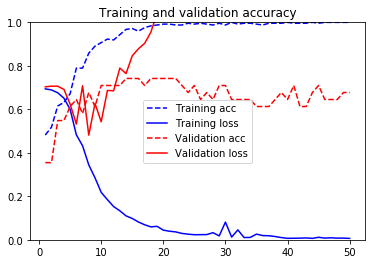

In [48]:
fig = plot(history_softmax)

Here we can see that using sigmoid as the activation function, the validation loss spike dramatically after 20 epochs without improvement of accuracy. This strongly suggest that after 20 epochs, the model become extremely overfit. 
Also, softmax become overfit after around 60 epochs and loss increase dramatically while accuracy is not improving.
Overall, Softmax perform better than sigmoid in term of accuracy and loss so we will use model with softmax as an activation function to predict test set.

This time, rather than training as much epochs we decided, we will use early stop to get the best model using before the model become overfit.

In [98]:
epochs = 200

def create_model_softmax(X_train, y_train, path, epochs):
    '''
    Generate LSTM model according to the hyperparameter stated aboved.
    Parameters-
    X_train: train data
    y_train: labeled data
    '''
    
    # Parameters
    embed_dim = 100
    lstm_out = grid_softmax['lstm_out']
    lstm_out2 = grid_softmax['lstm_out2']
    dropout_rate = grid_softmax['dropout_rate']
    dropout = grid_softmax['dropout']
    recurrent_dropout = grid_softmax['recurrent_dropout']
    batch_size = grid_softmax['batch_size']
    hidden = grid_softmax['hidden']
    epochs = epochs 
    
    np.random.seed(28)
    set_random_seed(28)
    
    start=time()
    model = Sequential()
    model.add(Embedding(unique_word2_count+1, embed_dim, input_length = max_len))
    for layer in range(hidden):
        model.add(LSTM(lstm_out, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True))
    model.add(LSTM(lstm_out2, dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dropout(dropout_rate))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

    #Save the weight of the best model
    filepath=path
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                                 save_best_only=True)
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0.0001,
                                                   patience=10, restore_best_weights=True)
    
    #DON'T FORGET TO USE ONE-HOT ENCODED LABEL! (y_train_dummy)
    history = model.fit(X_train, 
                        y_train_dummy, 
                        epochs = epochs, 
                        batch_size=batch_size, 
                        validation_data = [X_validate,y_validate_dummy], 
                        callbacks=[checkpoint, early_stopping], 
                        verbose = 1)
    
    model.save("models/full_model_softmax150.best.h5")
    print("total time:",time()-start)
    return model, history

In [100]:
model_softmax, history_softmax = create_model_softmax(X_train, y_train_dummy, "models/weights_softmax150.best.h5", epochs=100)

Train on 247 samples, validate on 31 samples
Epoch 1/100
247/247 [==============================] - 13s 52ms/step - loss: 0.6942 - acc: 0.4818 - val_loss: 0.7035 - val_acc: 0.3548

Epoch 00001: val_loss improved from inf to 0.70351, saving model to models/weights_softmax150.best.h5
Epoch 2/100
247/247 [==============================] - 7s 29ms/step - loss: 0.6892 - acc: 0.5182 - val_loss: 0.7065 - val_acc: 0.3548

Epoch 00002: val_loss did not improve from 0.70351
Epoch 3/100
247/247 [==============================] - 7s 26ms/step - loss: 0.6762 - acc: 0.6154 - val_loss: 0.7063 - val_acc: 0.5484

Epoch 00003: val_loss did not improve from 0.70351
Epoch 4/100
247/247 [==============================] - 6s 26ms/step - loss: 0.6512 - acc: 0.6316 - val_loss: 0.6917 - val_acc: 0.5484

Epoch 00004: val_loss improved from 0.70351 to 0.69166, saving model to models/weights_softmax150.best.h5
Epoch 5/100
247/247 [==============================] - 6s 26ms/step - loss: 0.6000 - acc: 0.6721 - val_l

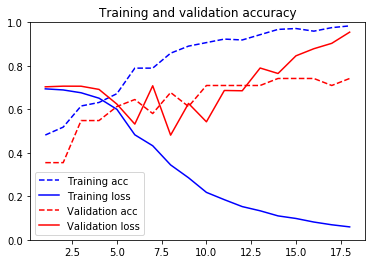

In [103]:
fig = plot(history_softmax)

The figure illustrate that the validation loss is higher than validation accuracy in the final epoch. This suggest that the model is overfitted. 

We will perform early stop for LSTM model with sigmoid activation funtion for comparison later.

In [65]:
def create_model_sigmoid2(X_train, y_train, path, epochs):
    '''
    Generate LSTM model according to the hyperparameter stated aboved.
    Parameters-
    X_train: train data
    y_train: labeled data
    '''
    
    # Parameters
    embed_dim = 100
    lstm_out = grid_sigmoid['lstm_out']
    lstm_out2 = grid_sigmoid['lstm_out2']
    dropout_rate = grid_sigmoid['dropout_rate']
    dropout = grid_sigmoid['dropout']
    recurrent_dropout = grid_sigmoid['recurrent_dropout']
    batch_size = grid_sigmoid['batch_size']
    hidden = grid_sigmoid['hidden']
    
    np.random.seed(28)
    set_random_seed(28)
    
    start=time()
    model = Sequential()
    model.add(Embedding(unique_word2_count+1, embed_dim, input_length = max_len))
    for layer in range(hidden):
        model.add(LSTM(lstm_out, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True))
    model.add(LSTM(lstm_out2, dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

    #Save the weight of the best model
    filepath=path
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                                 save_best_only=True)
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0.0001,
                                                   patience=10, restore_best_weights=True)
    
    #DON'T FORGET TO USE ONE-HOT ENCODED LABEL! (y_train_dummy)
    history = model.fit(X_train, 
                        y_train, 
                        epochs = epochs, 
                        batch_size=batch_size, 
                        validation_data = [X_validate,y_validate], 
                        callbacks=[checkpoint, early_stopping], 
                        verbose = 1)
    
    print("total time:",time()-start)
    return model, history

In [66]:
model_sigmoid2, history_sigmoid2 = create_model_sigmoid2(X_train, y_train, "models/weights_sigmoid150.best.h5", 100)

Train on 247 samples, validate on 31 samples
Epoch 1/100
247/247 [==============================] - 7s 30ms/step - loss: 0.6930 - acc: 0.5020 - val_loss: 0.6943 - val_acc: 0.3548

Epoch 00001: val_loss improved from inf to 0.69430, saving model to models/weights_sigmoid150.best.h5
Epoch 2/100
247/247 [==============================] - 5s 18ms/step - loss: 0.6908 - acc: 0.5344 - val_loss: 0.6937 - val_acc: 0.3871

Epoch 00002: val_loss improved from 0.69430 to 0.69373, saving model to models/weights_sigmoid150.best.h5
Epoch 3/100
247/247 [==============================] - 4s 18ms/step - loss: 0.6878 - acc: 0.5911 - val_loss: 0.6940 - val_acc: 0.4194

Epoch 00003: val_loss did not improve from 0.69373
Epoch 4/100
247/247 [==============================] - 4s 17ms/step - loss: 0.6846 - acc: 0.6397 - val_loss: 0.6937 - val_acc: 0.4194

Epoch 00004: val_loss improved from 0.69373 to 0.69370, saving model to models/weights_sigmoid150.best.h5
Epoch 5/100
247/247 [=============================

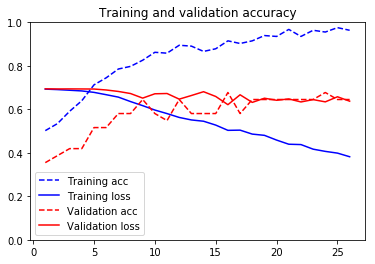

In [67]:
fig = plot(history_sigmoid2)

### <i>Model Evaluation

In [106]:
# Load weight that have the least validation loss from the callback

np.random.seed(28)
set_random_seed(28)

embed_dim = 100
lstm_out = grid_sigmoid['lstm_out']
lstm_out2 = grid_sigmoid['lstm_out2']
dropout_rate = grid_sigmoid['dropout_rate']
dropout = grid_sigmoid['dropout']
recurrent_dropout = grid_sigmoid['recurrent_dropout']
batch_size = grid_sigmoid['batch_size']
hidden = grid_sigmoid['hidden']

start=time()
model = Sequential()
model.add(Embedding(unique_word2_count+1, embed_dim, input_length = max_len))
for layer in range(hidden):
    model.add(LSTM(lstm_out, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True))
model.add(LSTM(lstm_out2, dropout=dropout, recurrent_dropout=recurrent_dropout))
model.add(Dropout(dropout_rate))
model.add(Dense(1,activation='sigmoid'))
model.load_weights("models/sigmoid.weights.best.h5")
model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [107]:
# LSTM with sigmoid as an activation function and use earlystop
sigmoid_loss_train, sigmoid_acc_train = model_sigmoid2.evaluate(X_train, y_train)
sigmoid_loss_validate, sigmoid_acc_validate = model_sigmoid2.evaluate(X_validate, y_validate)

# LSTM with softmax as an activation function and use earlystop
softmax_loss_train, softmax_acc_train = model_softmax.evaluate(X_train, y_train_dummy)
softmax_loss_validate, softmax_acc_validate = model_softmax.evaluate(X_validate, y_validate_dummy)

# LSTM with sigmoid as an activation function and use callback
sigmoid_loss_train_best, sigmoid_acc_train_best = model.evaluate(X_train, y_train)
sigmoid_loss_validate_best, sigmoid_acc_validate_best = model.evaluate(X_validate, y_validate)

31/31 [==============================] - 0s 3ms/step


In [198]:
print('Sigmoid accuracy in the training dataset is: ',round(sigmoid_acc_train, 2))
print('Sigmoid loss in the training dataset is: ', round(sigmoid_loss_train, 2))
print('Sigmoid accuracy in the validate dataset is: ', round(sigmoid_acc_validate, 2))
print('Sigmoid loss in the validate dataset is: ', round(sigmoid_loss_validate, 2))

print('\n')

print('Softmax accuracy in the training dataset is: ',round(softmax_acc_train, 2))
print('Softmax loss in the training dataset is: ', round(softmax_loss_train, 2))
print('Softmax accuracy in the validate dataset is: ', round(softmax_acc_validate, 2))
print('Softmax loss in the validate dataset is: ', round(softmax_loss_validate, 2))

print('\n')

print('Softmax accuracy in the training dataset is: ',round(sigmoid_acc_train_best, 2))
print('Softmax loss in the training dataset is: ', round(sigmoid_loss_train_best, 2))
print('Softmax accuracy in the validate dataset is: ', round(sigmoid_acc_validate_best, 2))
print('Softmax loss in the validate dataset is: ', round(sigmoid_loss_validate_best, 2))

Sigmoid accuracy in the training dataset is:  0.96
Sigmoid loss in the training dataset is:  0.49
Sigmoid accuracy in the validate dataset is:  0.68
Sigmoid loss in the validate dataset is:  0.62


Softmax accuracy in the training dataset is:  0.91
Softmax loss in the training dataset is:  0.3
Softmax accuracy in the validate dataset is:  0.68
Softmax loss in the validate dataset is:  0.48


Softmax accuracy in the training dataset is:  0.99
Softmax loss in the training dataset is:  0.18
Softmax accuracy in the validate dataset is:  0.84
Softmax loss in the validate dataset is:  0.45


Comparing between using earlystop and use only callback to save best weight, earlystop provide an easy way to save the best model with validation loss that didn't change for 10 consecutive times. However, this might cause the model to have not the least validation loss as didn't train for longer epochs. Save the weight of the model using only callback give the optimal validaiton loss but require to train for longer epochs.

From the result above, sigmoid activation function perform better than softmax with the accuracy in validate dataset of 0.84 and 0.68. Moreoever, the accuracy in LSTM that use sigmoid and callback function has highest validation accuracy.
Therefore, we will use LSTM with weight from the callback to predict the data in the test dataset.

#### Apply the model with test set

In [36]:
# Functions for evaluation.


def to_con_mat(con_mat):
    fig_cm = plt.figure()
    plt.imshow(con_mat, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.colorbar()
    classNames = ['Positive','Negative']
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]   
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(con_mat[i][j]))
    plt.show()
    return fig_cm

def ROC(fpr, tpr, ROC):
    fig_ROC, ax = plt.subplots(figsize=(6, 6))
    ax.plot(fpr, tpr, color="tomato", label="AUC=" + str(ROC))
    ax.plot(ax.get_ylim(), ax.get_xlim(), color="gray", linewidth=0.3)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)
    plt.legend(loc="lower right")
    plt.show() 
    return fig_ROC

def PR(recall, precision, AP):
    fig_PR, ax = plt.subplots(figsize=(6, 6))
    ax.plot(recall, precision, color="green", label="Average Precision=" + str(AP))
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(left=0, right=1)
    ax.set_ylim(bottom=0, top=1)
    plt.legend(loc="lower left")
    return fig_PR

In [110]:
# Load best model's weight and compile it

def load_model(weight_path):
    embed_dim = 100
    lstm_out = grid_sigmoid['lstm_out']
    lstm_out2 = grid_sigmoid['lstm_out2']
    dropout_rate = grid_sigmoid['dropout_rate']
    dropout = grid_sigmoid['dropout']
    recurrent_dropout = grid_sigmoid['recurrent_dropout']
    batch_size = grid_sigmoid['batch_size']
    hidden = grid_sigmoid['hidden']
    
    np.random.seed(28)
    set_random_seed(28)
    
    start=time()
    model = Sequential()
    model.add(Embedding(unique_word2_count+1, embed_dim, input_length = max_len))
    for layer in range(hidden):
        model.add(LSTM(lstm_out, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True))
    model.add(LSTM(lstm_out2, dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation='sigmoid'))
    model.load_weights(weight_path)
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    history = model
    return history

In [123]:
history = load_model("models/sigmoid.weights.best.h5")

In [124]:
history.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 100)          179800    
_________________________________________________________________
lstm_17 (LSTM)               (None, 500, 8)            3488      
_________________________________________________________________
lstm_18 (LSTM)               (None, 500, 8)            544       
_________________________________________________________________
lstm_19 (LSTM)               (None, 2)                 88        
_________________________________________________________________
dropout_6 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 3         
Total params: 183,923
Trainable params: 183,923
Non-trainable params: 0
_________________________________________________________________


In [125]:
# Perform LSTM with softmax as an activation function on test set

yhat = history.predict_classes(X_test)
# yhat = np.argmax(yhat, axis=1)
yhat_prob = history.predict_proba(X_test)
con_mat = confusion_matrix(y_test_data, yhat, labels=[1,0])
class_report = classification_report(y_test_data, yhat)
print(class_report)

              precision    recall  f1-score   support

         0.0       0.71      0.83      0.76        35
         1.0       0.79      0.66      0.72        35

    accuracy                           0.74        70
   macro avg       0.75      0.74      0.74        70
weighted avg       0.75      0.74      0.74        70



In [126]:
result_sigmoid = {}
result_sigmoid["acc"] = round(accuracy_score(y_test_data, yhat), 2)
result_sigmoid["recall"] = round(recall_score(y_test_data, yhat), 2)
result_sigmoid["fpr"], result_sigmoid["tpr"], result_sigmoid["thresholds"] = roc_curve(y_test_data, yhat_prob, pos_label=1)
result_sigmoid["ROC"] = round(roc_auc_score(y_test_data, yhat_prob), 2)
result_sigmoid["precision"], result_sigmoid["recall"], result_sigmoid["threshold"] = precision_recall_curve(y_test_data, yhat_prob, pos_label=1)
result_sigmoid["AP"] = round(average_precision_score(y_test_data, yhat_prob), 2)
result_sigmoid["con_mat"] = confusion_matrix(y_test_data, yhat, labels=[1,0])
result_sigmoid["yhat"] = yhat

print("Model accuracy is: ", result_sigmoid["acc"])

Model accuracy is:  0.74


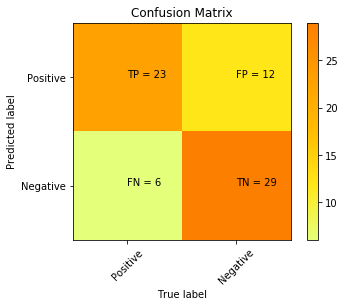

In [141]:
pic_sigmoid = to_con_mat(result_sigmoid["con_mat"])

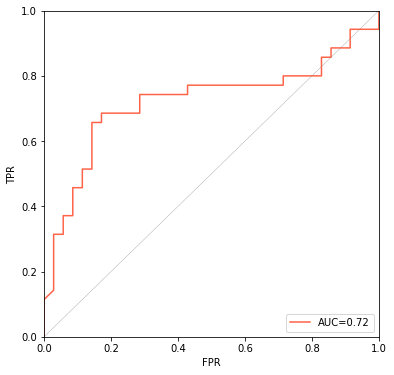

In [142]:
fig_ROC_sigmoid = ROC(result_sigmoid["fpr"], result_sigmoid["tpr"], result_sigmoid["ROC"])

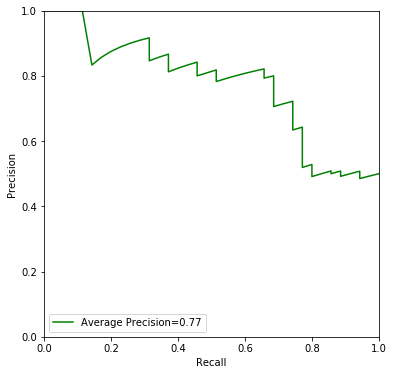

In [143]:
fig_PR_sigmoid = PR(result_sigmoid["recall"], result_sigmoid["precision"], result_sigmoid["AP"])

According to the result above, the model perform quite well and effectively with the accuracy of 0.74 with AUC ROC of 0.72

### Use pretain network, Global Vector (GloVe)

In [36]:
# Create 100 vector dimension for GloVe model
emb_dict = {}

# Import pretrain words vector into dictionary
glove = open(r'pretrain/glove.6B.100d.txt','r', encoding='utf8')
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

In [37]:
print(list(emb_dict.items())[0:2])

[('the', array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0

In [40]:
# Apply the GloVe word vector into our tokenized word
GLOVE_DIM = 100
emb_matrix = np.zeros((unique_word2_count+1, GLOVE_DIM))
for word, index in tokenizer.word_index.items():
    if index < unique_word2_count:
        vect = emb_dict.get(word)
        if vect is not None:
            emb_matrix[index] = vect
    else:
        break

In [41]:
print("There are total of", len(emb_matrix)-1, "words our dataset")

There are total of 1797 words our dataset


In [43]:
# Generate the same architecture of the LSTM model that apply with GloVe word vector
# First try train the model with dsiable (trainable=False) training of word embedding to see the accuracy.

glove_model = Sequential()
glove_model.add(Embedding(unique_word2_count+1, GLOVE_DIM, input_length = max_len, weights=[emb_matrix], trainable=False))
for layer in range(grid_sigmoid['hidden']):
    glove_model.add(LSTM(grid_sigmoid['lstm_out2'], dropout=grid_sigmoid['dropout'], recurrent_dropout=grid_sigmoid['recurrent_dropout'], return_sequences=True))
glove_model.add(LSTM(grid_sigmoid['lstm_out2'], dropout=grid_sigmoid['dropout'], recurrent_dropout=grid_sigmoid['recurrent_dropout']))
glove_model.add(Dropout(grid_sigmoid['dropout_rate']))
glove_model.add(Dense(1,activation='sigmoid'))
glove_model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
glove_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 100)          179800    
_________________________________________________________________
lstm_7 (LSTM)                (None, 500, 2)            824       
_________________________________________________________________
lstm_8 (LSTM)                (None, 500, 2)            40        
_________________________________________________________________
lstm_9 (LSTM)                (None, 2)                 40        
_________________________________________________________________
dropout_3 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 180,707
Trainable params: 907
Non-trainable params: 179,800
_________________________________________________________________


In [46]:
np.random.seed(28)
set_random_seed(28)

# Hyperparameters
embed_dim = 200
lstm_out = grid_sigmoid['lstm_out']
lstm_out2 = grid_sigmoid['lstm_out2']
dropout_rate = grid_sigmoid['dropout_rate']
dropout = grid_sigmoid['dropout']
recurrent_dropout = grid_sigmoid['recurrent_dropout']
batch_size = grid_sigmoid['batch_size']
epochs = 200

#Save the weight of the best model
filepath="models/GloVe_untrain_weights.best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
callbacks_list = [checkpoint]

start=time()
history_glove = glove_model.fit(X_train, 
                                y_train, 
                                epochs = epochs, 
                                batch_size=batch_size, 
                                validation_data = [X_validate,y_validate], 
                                callbacks=callbacks_list, 
                                verbose= 1)

print("total time:",time()-start)

Train on 247 samples, validate on 31 samples
Epoch 1/200
247/247 [==============================] - 4s 18ms/step - loss: 0.4926 - acc: 0.7814 - val_loss: 0.5858 - val_acc: 0.6452

Epoch 00001: val_loss improved from inf to 0.58583, saving model to models/GloVe_untrain_weights.best.h5
Epoch 2/200
247/247 [==============================] - 4s 16ms/step - loss: 0.4922 - acc: 0.7490 - val_loss: 0.5876 - val_acc: 0.6452

Epoch 00002: val_loss did not improve from 0.58583
Epoch 3/200
247/247 [==============================] - 4s 17ms/step - loss: 0.5206 - acc: 0.7368 - val_loss: 0.5932 - val_acc: 0.6452

Epoch 00003: val_loss did not improve from 0.58583
Epoch 4/200
247/247 [==============================] - 4s 16ms/step - loss: 0.5039 - acc: 0.7530 - val_loss: 0.6036 - val_acc: 0.6774

Epoch 00004: val_loss did not improve from 0.58583
Epoch 5/200
247/247 [==============================] - 4s 16ms/step - loss: 0.5043 - acc: 0.7571 - val_loss: 0.5915 - val_acc: 0.6452

Epoch 00005: val_loss 

247/247 [==============================] - 4s 16ms/step - loss: 0.4744 - acc: 0.7247 - val_loss: 0.6145 - val_acc: 0.6774

Epoch 00043: val_loss did not improve from 0.56565
Epoch 44/200
247/247 [==============================] - 4s 17ms/step - loss: 0.4682 - acc: 0.7895 - val_loss: 0.6376 - val_acc: 0.6452

Epoch 00044: val_loss did not improve from 0.56565
Epoch 45/200
247/247 [==============================] - 4s 16ms/step - loss: 0.4692 - acc: 0.7692 - val_loss: 0.6252 - val_acc: 0.6774

Epoch 00045: val_loss did not improve from 0.56565
Epoch 46/200
247/247 [==============================] - 4s 16ms/step - loss: 0.4770 - acc: 0.7611 - val_loss: 0.6004 - val_acc: 0.6452

Epoch 00046: val_loss did not improve from 0.56565
Epoch 47/200
247/247 [==============================] - 4s 16ms/step - loss: 0.5054 - acc: 0.7126 - val_loss: 0.6005 - val_acc: 0.6774

Epoch 00047: val_loss did not improve from 0.56565
Epoch 48/200
247/247 [==============================] - 4s 17ms/step - loss: 0

247/247 [==============================] - 4s 15ms/step - loss: 0.4302 - acc: 0.7895 - val_loss: 0.6344 - val_acc: 0.6774

Epoch 00087: val_loss did not improve from 0.56565
Epoch 88/200
247/247 [==============================] - 4s 15ms/step - loss: 0.4548 - acc: 0.7409 - val_loss: 0.6399 - val_acc: 0.6774

Epoch 00088: val_loss did not improve from 0.56565
Epoch 89/200
247/247 [==============================] - 4s 16ms/step - loss: 0.4441 - acc: 0.7895 - val_loss: 0.6243 - val_acc: 0.6774

Epoch 00089: val_loss did not improve from 0.56565
Epoch 90/200
247/247 [==============================] - 4s 15ms/step - loss: 0.4257 - acc: 0.7854 - val_loss: 0.6040 - val_acc: 0.6774

Epoch 00090: val_loss did not improve from 0.56565
Epoch 91/200
247/247 [==============================] - 4s 15ms/step - loss: 0.3938 - acc: 0.7895 - val_loss: 0.5717 - val_acc: 0.6774

Epoch 00091: val_loss did not improve from 0.56565
Epoch 92/200
247/247 [==============================] - 4s 16ms/step - loss: 0


Epoch 00130: val_loss did not improve from 0.56565
Epoch 131/200
247/247 [==============================] - 4s 16ms/step - loss: 0.4242 - acc: 0.7733 - val_loss: 0.6256 - val_acc: 0.6452

Epoch 00131: val_loss did not improve from 0.56565
Epoch 132/200
247/247 [==============================] - 4s 16ms/step - loss: 0.4134 - acc: 0.7854 - val_loss: 0.6003 - val_acc: 0.7097

Epoch 00132: val_loss did not improve from 0.56565
Epoch 133/200
247/247 [==============================] - 4s 16ms/step - loss: 0.3943 - acc: 0.7773 - val_loss: 0.5930 - val_acc: 0.7097

Epoch 00133: val_loss did not improve from 0.56565
Epoch 134/200
247/247 [==============================] - 4s 15ms/step - loss: 0.4247 - acc: 0.7692 - val_loss: 0.5995 - val_acc: 0.6774

Epoch 00134: val_loss did not improve from 0.56565
Epoch 135/200
247/247 [==============================] - 4s 15ms/step - loss: 0.4159 - acc: 0.7976 - val_loss: 0.5888 - val_acc: 0.7097

Epoch 00135: val_loss did not improve from 0.56565
Epoch 13

The figure shows that disable the training of the GloVe word embedding still leads to slowly decrease in loss and accuracy of the model. However, around 60 epochs the model become overfit and didn't perform well.

Next, we will enable training of the GloVe word embedding to see whether it helps in accuracy or not.

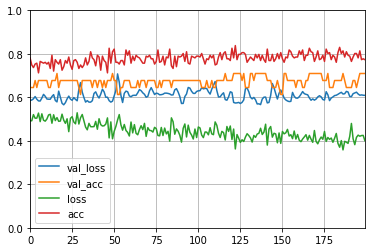

In [47]:
pd.DataFrame(history_glove.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [173]:
# Generate the same architecture of the LSTM model that apply with GloVe word vector
# Perform longer epochs with early stop to prevent overfit

glove_model = Sequential()
glove_model.add(Embedding(unique_word2_count+1, GLOVE_DIM, input_length = max_len, weights=[emb_matrix], trainable=False))
for layer in range(grid_sigmoid['hidden']):
    glove_model.add(LSTM(grid_sigmoid['lstm_out2'], dropout=grid_sigmoid['dropout'], recurrent_dropout=grid_sigmoid['recurrent_dropout'], return_sequences=True))
glove_model.add(LSTM(grid_sigmoid['lstm_out2'], dropout=grid_sigmoid['dropout'], recurrent_dropout=grid_sigmoid['recurrent_dropout']))
glove_model.add(Dropout(grid_sigmoid['dropout_rate']))
glove_model.add(Dense(1,activation='sigmoid'))
glove_model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
glove_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 500, 100)          179800    
_________________________________________________________________
lstm_54 (LSTM)               (None, 500, 2)            824       
_________________________________________________________________
lstm_55 (LSTM)               (None, 500, 2)            40        
_________________________________________________________________
lstm_56 (LSTM)               (None, 2)                 40        
_________________________________________________________________
dropout_18 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 3         
Total params: 180,707
Trainable params: 907
Non-trainable params: 179,800
_________________________________________________________________


In [174]:
np.random.seed(28)
set_random_seed(28)

epochs = 200
batch_size = grid_softmax['batch_size']

#Save the weight of the best model
filepath="models/GloVe_best_untrain_weights.best.early.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0.0001,
                                                   patience=10, restore_best_weights=True)

start=time()
history_glove = glove_model.fit(X_train, 
                                y_train, 
                                epochs = epochs, 
                                batch_size=batch_size, 
                                validation_data = [X_validate,y_validate],
                                callbacks=[checkpoint,early_stopping], 
                                verbose = 1)

print("total time:",time()-start)

Train on 247 samples, validate on 31 samples
Epoch 1/200
247/247 [==============================] - 11s 46ms/step - loss: 0.6966 - acc: 0.4777 - val_loss: 0.6800 - val_acc: 0.6452

Epoch 00001: val_loss improved from inf to 0.67999, saving model to models/GloVe_best_untrain_weights.best.early.h5
Epoch 2/200
247/247 [==============================] - 4s 18ms/step - loss: 0.6897 - acc: 0.5385 - val_loss: 0.6810 - val_acc: 0.7742

Epoch 00002: val_loss did not improve from 0.67999
Epoch 3/200
247/247 [==============================] - 4s 18ms/step - loss: 0.6897 - acc: 0.5425 - val_loss: 0.6815 - val_acc: 0.7419

Epoch 00003: val_loss did not improve from 0.67999
Epoch 4/200
247/247 [==============================] - 4s 18ms/step - loss: 0.6899 - acc: 0.5385 - val_loss: 0.6809 - val_acc: 0.7097

Epoch 00004: val_loss did not improve from 0.67999
Epoch 5/200
247/247 [==============================] - 4s 18ms/step - loss: 0.6918 - acc: 0.4737 - val_loss: 0.6811 - val_acc: 0.6774

Epoch 0000

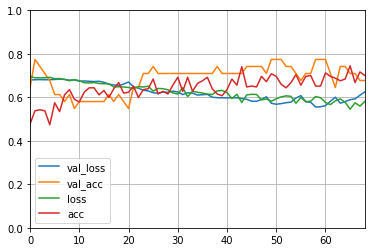

In [175]:
pd.DataFrame(history_glove.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [189]:
# Load the best weight into the model

glove_model = Sequential()
glove_model.add(Embedding(unique_word2_count+1, GLOVE_DIM, input_length = max_len, weights=[emb_matrix], trainable=False))
for layer in range(grid_sigmoid['hidden']):
    glove_model.add(LSTM(grid_sigmoid['lstm_out2'], dropout=grid_sigmoid['dropout'], recurrent_dropout=grid_sigmoid['recurrent_dropout'], return_sequences=True))
glove_model.add(LSTM(grid_sigmoid['lstm_out2'], dropout=grid_sigmoid['dropout'], recurrent_dropout=grid_sigmoid['recurrent_dropout']))
glove_model.add(Dropout(grid_sigmoid['dropout_rate']))
glove_model.add(Dense(1,activation='sigmoid'))
glove_model.load_weights('models/GloVe_untrain_weights.best.h5')
glove_model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
glove_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 500, 100)          179800    
_________________________________________________________________
lstm_66 (LSTM)               (None, 500, 2)            824       
_________________________________________________________________
lstm_67 (LSTM)               (None, 500, 2)            40        
_________________________________________________________________
lstm_68 (LSTM)               (None, 2)                 40        
_________________________________________________________________
dropout_22 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 3         
Total params: 180,707
Trainable params: 907
Non-trainable params: 179,800
_________________________________________________________________


In [197]:
glove_train_loss, glove_train_acc = glove_model.evaluate(X_train, y_train)
glove_validate_loss, glove_validate_acc = glove_model.evaluate(X_validate, y_validate)

31/31 [==============================] - 0s 4ms/step


In [199]:
print('Glove accuracy in the train dataset is: ', round(glove_train_acc, 2))
print('Glove loss in the train dataset is: ', round(glove_train_loss, 2))

print('Glove accuracy in the validate dataset is: ', round(glove_validate_acc, 2))
print('Glove loss in the validate dataset is: ', round(glove_validate_loss, 2))

Glove accuracy in the train dataset is:  0.8
Glove loss in the train dataset is:  0.49
Glove accuracy in the validate dataset is:  0.74
Glove loss in the validate dataset is:  0.52


In [190]:
yhat = glove_model.predict_classes(X_test)
# yhat = np.argmax(yhat, axis=1) # for softmax
# yhat_prob = glove_model.predict_proba(X_test)[:,1] # for softmax
yhat_prob = glove_model.predict_proba(X_test)
con_mat = confusion_matrix(y_test_data, yhat, labels=[1,0])
class_report = classification_report(y_test_data, yhat)

In [191]:
print(class_report)

              precision    recall  f1-score   support

         0.0       0.70      0.60      0.65        35
         1.0       0.65      0.74      0.69        35

    accuracy                           0.67        70
   macro avg       0.68      0.67      0.67        70
weighted avg       0.68      0.67      0.67        70



In [192]:
result_glove = {}
result_glove["acc"] = round(accuracy_score(y_test_data, yhat), 2)
result_glove["recall"] = round(recall_score(y_test_data, yhat), 2)
result_glove["fpr"], result_glove["tpr"], result_glove["thresholds"] = roc_curve(y_test_data, yhat_prob, pos_label=1)
result_glove["ROC"] = round(roc_auc_score(y_test_data, yhat_prob), 2)
result_glove["precision"], result_glove["recall"], result_glove["threshold"] = precision_recall_curve(y_test_data, yhat_prob, pos_label=1)
result_glove["AP"] = round(average_precision_score(y_test_data, yhat_prob), 2)
result_glove["con_mat"] = confusion_matrix(y_test_data, yhat, labels=[1,0])

print("Model accuracy is: ", result_glove["acc"])

Model accuracy is:  0.67


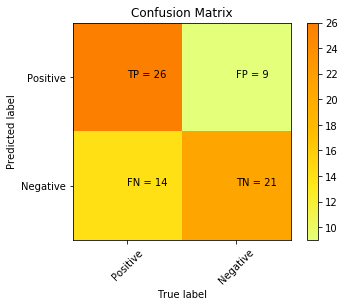

In [193]:
pic_glove = to_con_mat(result_glove["con_mat"])

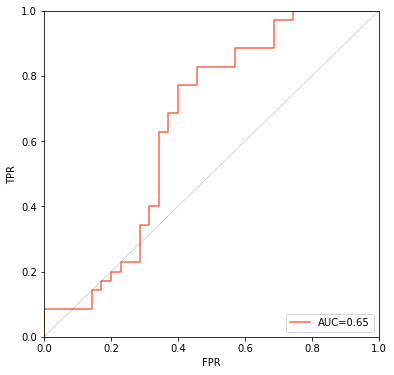

In [194]:
fig_ROC_glove = ROC(result_glove["fpr"], result_glove["tpr"], result_glove["ROC"])

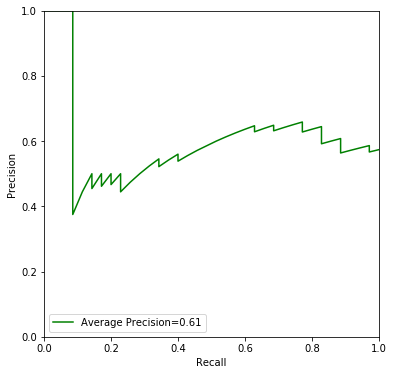

In [195]:
fig_PR_glove = PR(result_glove["recall"], result_glove["precision"], result_glove["AP"])

## <b>Result</b>

According to the figure above, model with pretain GloVe perform worse than using no-pretrain LSTM model. This might be due to the dataset word vector in the dataset doesn't have the appropriate word with GloVe.
However, Glove embedding word vector help to stabilize the accuracy and loss between training set and validate set significantly. This helps to model to get the optimal weight faster than newly trained model.

### <b>Gated Recurrent Unit (GRU)</b>

After using LSTM to predict the sentiment of comments, we want to try to use GRU to compare which model has better accuracy. To make it easier, we will use the same model architecture as LSTM. Also, we will use gridsearch to find the optimal hyperparameters for GRU.

In [200]:
# Creat function for GRU training

def create_model_GRU_softmax(nodes=1, dropout_rate=0, dropout=0.1, recurrent_dropout=0.1, nodes2=1, hidden=1):
    model = Sequential()
    model.add(Embedding(unique_word2_count+1, embed_dim, input_length = max_len))
    for layer in range(hidden):
        model.add(GRU(nodes, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True))
    model.add(GRU(nodes2, dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return model

In [201]:
# Parameters for Randomsearch

np.random.seed(28)
set_random_seed(28)

start=time()

model_sigmoid = KerasClassifier(build_fn=create_model_GRU_softmax, verbose=1, epochs=150)

nodes = [1,2,8,16,32]
nodes2 = [1,2,8,16,32]
dropout_rate = [0.1]
dropout = [0.1]
recurrent_dropout = [0.1]
batch_size = [16, 32, 64]
hidden = [1,2,3]

param_grid = dict(nodes=nodes,
                  nodes2 = nodes2,
                  dropout_rate=dropout_rate, 
                  dropout=dropout, 
                  recurrent_dropout=recurrent_dropout,
                  batch_size=batch_size,
                  hidden = hidden)

grid = RandomizedSearchCV(estimator=model_sigmoid, 
                          param_distributions=param_grid,
                          scoring="accuracy",
                          cv=ShuffleSplit(test_size=0.10, random_state=28, n_splits=1))


In [204]:
np.random.seed(28)
set_random_seed(28)

filepath = "models/GRU_grid.h5"
history = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0.0001,
                                                   patience=10, restore_best_weights=True)
    
grid_result = grid.fit(X_train, 
                       y_train, 
                       callbacks=[early_stopping,history], 
                       validation_data = [X_validate,y_validate],
                       epochs=100)

print("total time:",time()-start)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Train on 222 samples, validate on 31 samples
Epoch 1/100
222/222 [==============================] - 13s 57ms/step - loss: 0.6812 - acc: 0.5721 - val_loss: 0.6804 - val_acc: 0.5484

Epoch 00001: val_loss improved from inf to 0.68041, saving model to models/GRU_grid.h5
Epoch 2/100
222/222 [==============================] - 4s 20ms/step - loss: 0.6288 - acc: 0.7703 - val_loss: 0.6550 - val_acc: 0.6452

Epoch 00002: val_loss improved from 0.68041 to 0.65501, saving model to models/GRU_grid.h5
Epoch 3/100
222/222 [==============================] - 5s 21ms/step - loss: 0.5488 - acc: 0.8198 - val_loss: 0.6008 - val_acc: 0.7419

Epoch 00003: val_loss improved from 0.65501 to 0.60083, saving model to models/GRU_grid.h5
Epoch 4/100
222/222 [==============================] - 4s 20ms/step - loss: 0.4661 - acc: 0.8288 - val_loss: 0.5513 - val_acc: 0.7742

Epoch 00004: val_loss improved from 0.60083 to 0.55130, saving model to models/GRU_grid.h5
Epoch 5/100
222/222 [==============================] -

222/222 [==============================] - 4s 17ms/step - loss: 0.1684 - acc: 0.9955 - val_loss: 0.5595 - val_acc: 0.7419

Epoch 00032: val_loss did not improve from 0.47282
Epoch 33/100
222/222 [==============================] - 4s 16ms/step - loss: 0.1724 - acc: 0.9865 - val_loss: 0.5320 - val_acc: 0.7419

Epoch 00033: val_loss did not improve from 0.47282
Epoch 34/100
222/222 [==============================] - 4s 17ms/step - loss: 0.1728 - acc: 0.9865 - val_loss: 0.5792 - val_acc: 0.7419

Epoch 00034: val_loss did not improve from 0.47282
Epoch 35/100
222/222 [==============================] - 4s 16ms/step - loss: 0.1581 - acc: 0.9775 - val_loss: 0.5887 - val_acc: 0.7419

Epoch 00035: val_loss did not improve from 0.47282
Epoch 36/100
222/222 [==============================] - 4s 16ms/step - loss: 0.1719 - acc: 0.9910 - val_loss: 0.5813 - val_acc: 0.7419

Epoch 00036: val_loss did not improve from 0.47282
Epoch 37/100
222/222 [==============================] - 4s 16ms/step - loss: 0


Epoch 00016: val_loss did not improve from 0.45395
Epoch 17/100
222/222 [==============================] - 3s 15ms/step - loss: 0.3028 - acc: 0.9595 - val_loss: 0.5740 - val_acc: 0.7097

Epoch 00017: val_loss did not improve from 0.45395
Epoch 18/100
222/222 [==============================] - 3s 15ms/step - loss: 0.3141 - acc: 0.9099 - val_loss: 0.5824 - val_acc: 0.7097

Epoch 00018: val_loss did not improve from 0.45395
Epoch 19/100
222/222 [==============================] - 3s 15ms/step - loss: 0.3008 - acc: 0.9414 - val_loss: 0.5931 - val_acc: 0.7097

Epoch 00019: val_loss did not improve from 0.45395
Epoch 20/100
222/222 [==============================] - 3s 15ms/step - loss: 0.2998 - acc: 0.9279 - val_loss: 0.5879 - val_acc: 0.7097

Epoch 00020: val_loss did not improve from 0.45395
25/25 [==============================] - 3s 140ms/step
Train on 222 samples, validate on 31 samples
Epoch 1/100
222/222 [==============================] - 15s 69ms/step - loss: 0.6927 - acc: 0.5045 - 

222/222 [==============================] - 14s 64ms/step - loss: 0.6933 - acc: 0.5000 - val_loss: 0.6924 - val_acc: 0.4516

Epoch 00001: val_loss did not improve from 0.45395
Epoch 2/100
222/222 [==============================] - 2s 10ms/step - loss: 0.6885 - acc: 0.6892 - val_loss: 0.6909 - val_acc: 0.4839

Epoch 00002: val_loss did not improve from 0.45395
Epoch 3/100
222/222 [==============================] - 2s 10ms/step - loss: 0.6842 - acc: 0.7613 - val_loss: 0.6899 - val_acc: 0.4516

Epoch 00003: val_loss did not improve from 0.45395
Epoch 4/100
222/222 [==============================] - 2s 10ms/step - loss: 0.6786 - acc: 0.7748 - val_loss: 0.6885 - val_acc: 0.4516

Epoch 00004: val_loss did not improve from 0.45395
Epoch 5/100
222/222 [==============================] - 2s 10ms/step - loss: 0.6738 - acc: 0.7973 - val_loss: 0.6866 - val_acc: 0.5161

Epoch 00005: val_loss did not improve from 0.45395
Epoch 6/100
222/222 [==============================] - 2s 10ms/step - loss: 0.665

222/222 [==============================] - 2s 10ms/step - loss: 0.3226 - acc: 0.9820 - val_loss: 0.5863 - val_acc: 0.7742

Epoch 00045: val_loss did not improve from 0.45395
Epoch 46/100
222/222 [==============================] - 2s 10ms/step - loss: 0.3231 - acc: 0.9820 - val_loss: 0.5845 - val_acc: 0.7742

Epoch 00046: val_loss did not improve from 0.45395
Epoch 47/100
222/222 [==============================] - 2s 10ms/step - loss: 0.3036 - acc: 0.9865 - val_loss: 0.5844 - val_acc: 0.7419

Epoch 00047: val_loss did not improve from 0.45395
Epoch 48/100
222/222 [==============================] - 2s 10ms/step - loss: 0.3040 - acc: 0.9685 - val_loss: 0.5851 - val_acc: 0.7419

Epoch 00048: val_loss did not improve from 0.45395
Epoch 49/100
222/222 [==============================] - 2s 10ms/step - loss: 0.2891 - acc: 0.9820 - val_loss: 0.5861 - val_acc: 0.7419

Epoch 00049: val_loss did not improve from 0.45395
Epoch 50/100
222/222 [==============================] - 2s 10ms/step - loss: 0

247/247 [==============================] - 4s 17ms/step - loss: 0.2599 - acc: 0.9514 - val_loss: 0.5399 - val_acc: 0.7097

Epoch 00012: val_loss did not improve from 0.45395
Epoch 13/100
247/247 [==============================] - 4s 17ms/step - loss: 0.2089 - acc: 0.9393 - val_loss: 0.6153 - val_acc: 0.7097

Epoch 00013: val_loss did not improve from 0.45395
Epoch 14/100
247/247 [==============================] - 4s 17ms/step - loss: 0.1671 - acc: 0.9757 - val_loss: 0.5971 - val_acc: 0.7742

Epoch 00014: val_loss did not improve from 0.45395
Epoch 15/100
247/247 [==============================] - 4s 17ms/step - loss: 0.1381 - acc: 0.9757 - val_loss: 0.6693 - val_acc: 0.7419

Epoch 00015: val_loss did not improve from 0.45395
Epoch 16/100
247/247 [==============================] - 4s 17ms/step - loss: 0.1241 - acc: 0.9838 - val_loss: 0.6505 - val_acc: 0.7419

Epoch 00016: val_loss did not improve from 0.45395
Epoch 17/100
247/247 [==============================] - 4s 17ms/step - loss: 0

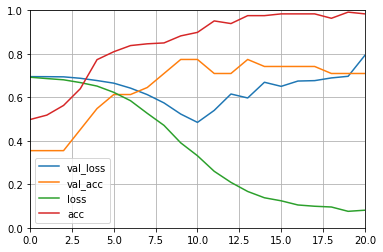

In [205]:
pd.DataFrame(grid_result.best_estimator_.model.history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [206]:
joblib.dump(grid_result.best_estimator_.model, 'models/GRU_grid_model.pkl')
joblib.dump(grid_result.best_params_, 'models/GRU_grid_best_params.pkl')

['models/GRU_grid_best_params.pkl']

In [207]:
grid_result.best_estimator_.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 500, 200)          359600    
_________________________________________________________________
gru_38 (GRU)                 (None, 500, 16)           10416     
_________________________________________________________________
gru_39 (GRU)                 (None, 500, 16)           1584      
_________________________________________________________________
gru_40 (GRU)                 (None, 500, 16)           1584      
_________________________________________________________________
gru_41 (GRU)                 (None, 8)                 600       
_________________________________________________________________
dropout_35 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 9         
Total para

In [208]:
grid_result.best_params_

{'recurrent_dropout': 0.1,
 'nodes2': 8,
 'nodes': 16,
 'hidden': 3,
 'dropout_rate': 0.1,
 'dropout': 0.1,
 'batch_size': 64}

In [209]:
grid_result = joblib.load('models/GRU_grid_best_params.pkl')

#### GRU model with tuned hyperparameter

In [210]:
# Hyperparameters

embed_dim = 100
nodes = grid_result['nodes']
nodes2 = grid_result['nodes2']
dropout_rate = grid_result['dropout_rate']
dropout = grid_result['dropout_rate']
recurrent_dropout = grid_result['dropout_rate']
batch_size = grid_result['batch_size']
hidden = grid_result['hidden']
epochs = 200

In [216]:
# We use earlystop to get the best weight that have least valalidation loss. The model will be use for prediction.

def create_model_GRU(X_train, y_train, path):
    '''
    Generate LSTM model according to the hyperparameter stated aboved.
    Parameters-
    X_train: train data
    y_train: labeled data
    path: path to keep best model
    '''

    set_random_seed(28)
    np.random.seed(28)

    start=time()
    model = Sequential()
    model.add(Embedding(unique_word2_count+1, embed_dim, input_length = max_len))
    for layer in range(hidden):
        model.add(GRU(nodes, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True))
    model.add(GRU(nodes2, dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    #Save the weight of the best model
    
    filepath=path
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta = 0.0001,
                                                   patience=10, restore_best_weights=True)

    history = model.fit(X_train, 
                        y_train, 
                        epochs = epochs, 
                        batch_size=batch_size, 
                        validation_data = [X_validate,y_validate], 
                        callbacks= [checkpoint, early_stopping], 
                        verbose = 1)
    
    print("total time:",time()-start)
    return model, history

In [217]:
model_GRU, history_GRU = create_model_GRU(X_train, y_train, "models/weights_GRU.best.h5")

Train on 247 samples, validate on 31 samples
Epoch 1/200
247/247 [==============================] - 20s 80ms/step - loss: 0.6930 - acc: 0.4939 - val_loss: 0.6963 - val_acc: 0.3548

Epoch 00001: val_loss improved from inf to 0.69631, saving model to models/weights_GRU.best.h5
Epoch 2/200
247/247 [==============================] - 3s 13ms/step - loss: 0.6891 - acc: 0.5223 - val_loss: 0.6957 - val_acc: 0.3548

Epoch 00002: val_loss improved from 0.69631 to 0.69569, saving model to models/weights_GRU.best.h5
Epoch 3/200
247/247 [==============================] - 3s 13ms/step - loss: 0.6844 - acc: 0.5263 - val_loss: 0.6948 - val_acc: 0.3548

Epoch 00003: val_loss improved from 0.69569 to 0.69485, saving model to models/weights_GRU.best.h5
Epoch 4/200
247/247 [==============================] - 3s 13ms/step - loss: 0.6779 - acc: 0.5911 - val_loss: 0.6924 - val_acc: 0.4194

Epoch 00004: val_loss improved from 0.69485 to 0.69245, saving model to models/weights_GRU.best.h5
Epoch 5/200
247/247 [=

In [218]:
model_GRU.save('models/model.GRU.h5')

In [134]:
model_GRU = load_model('models/model.GRU.h5')

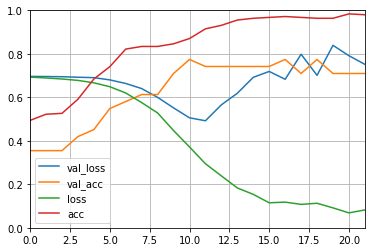

In [219]:
pd.DataFrame(history_GRU.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [135]:
model_GRU.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_41 (Embedding)     (None, 500, 100)          179800    
_________________________________________________________________
gru_54 (GRU)                 (None, 500, 16)           5616      
_________________________________________________________________
gru_55 (GRU)                 (None, 500, 16)           1584      
_________________________________________________________________
gru_56 (GRU)                 (None, 500, 16)           1584      
_________________________________________________________________
gru_57 (GRU)                 (None, 8)                 600       
_________________________________________________________________
dropout_39 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 9         
Total para

In [136]:
# Perform on test set

yhat = model_GRU.predict_classes(X_test)
# yhat = np.argmax(yhat, axis=1) # for softmax
# yhat_prob = model_GRU.predict_proba(X_test)[:,1] # for softmax
yhat_prob = model_GRU.predict_proba(X_test) 
class_report = classification_report(y_test_data, yhat)
con_mat = confusion_matrix(y_test_data, yhat, labels=[1,0])

In [137]:
result_GRU = {}
result_GRU["acc"] = round(accuracy_score(y_test_data, yhat), 2)
result_GRU["recall"] = round(recall_score(y_test_data, yhat), 2)
result_GRU["fpr"], result_GRU["tpr"], result_GRU["thresholds"] = roc_curve(y_test_data, yhat_prob, pos_label=1)
result_GRU["ROC"] = round(roc_auc_score(y_test_data, yhat_prob), 2)
result_GRU["precision"], result_GRU["recall"], result_GRU["threshold"] = precision_recall_curve(y_test_data, yhat_prob, pos_label=1)
result_GRU["AP"] = round(average_precision_score(y_test_data, yhat_prob), 2)
result_GRU["con_mat"] = confusion_matrix(y_test_data, yhat, labels=[1,0])
result_GRU["yhat"] = yhat

print("Model accuracy is: ", result_GRU["acc"])

Model accuracy is:  0.71


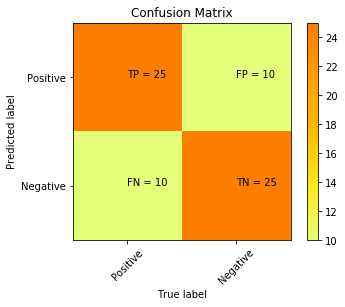

In [138]:
pic_GRU = to_con_mat(result_GRU["con_mat"])

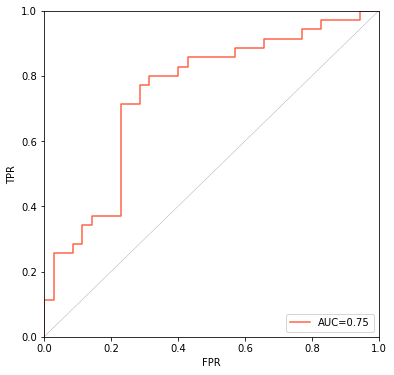

In [139]:
fig_ROC_GRU = ROC(result_GRU["fpr"], result_GRU["tpr"], result_GRU["ROC"])

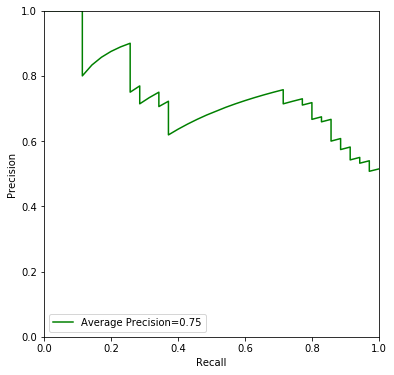

In [140]:
fig_PR_GRU = PR(result_GRU["recall"], result_GRU["precision"], result_GRU["AP"])

### LSTM vs GRU mode comparison

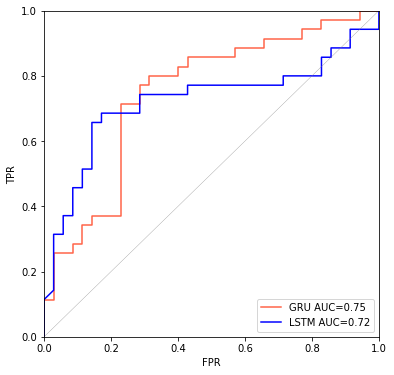

In [128]:
fig_ROC, ax = plt.subplots(figsize=(6, 6))
ax.plot(result_GRU["fpr"], result_GRU["tpr"], color="tomato", label="GRU AUC=" + str(result_GRU["ROC"]))
ax.plot(result_sigmoid["fpr"], result_sigmoid["tpr"], color="blue", label="LSTM AUC=" + str(result_sigmoid["ROC"]))
ax.plot(ax.get_ylim(), ax.get_xlim(), color="gray", linewidth=0.3)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_xlim(left=0, right=1)
ax.set_ylim(bottom=0, top=1)
plt.legend(loc="lower right")
plt.show() 

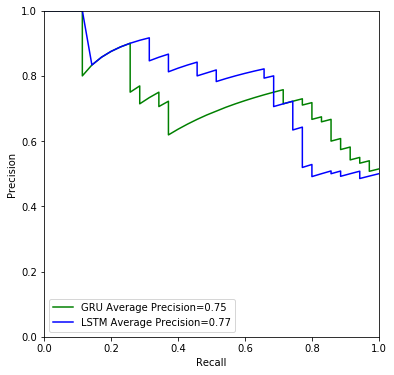

In [130]:
fig_PR, ax = plt.subplots(figsize=(6, 6))
ax.plot(result_GRU["recall"], result_GRU["precision"], color="green", label="GRU Average Precision=" + str(result_GRU["AP"]))
ax.plot(result_sigmoid["recall"], result_sigmoid["precision"], color="blue", label="LSTM Average Precision=" + str(result_sigmoid["AP"]))
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_xlim(left=0, right=1)
ax.set_ylim(bottom=0, top=1)
plt.legend(loc="lower left")

In [131]:
print("GRU Model accuracy is: ", result_GRU["acc"])
print("LSTM Model accuracy is: ", result_sigmoid["acc"])

GRU Model accuracy is:  0.71
LSTM Model accuracy is:  0.74


LSTM model perform better than GRU because it gives higher accuracy (0.74) and PR score (0.77). Eventhough LSTM perform has lower ROC score (0.72), we want to get high accuracy of true positive class (comments) and we accept false negative class as we focus on only negative comments. 

## <i>Analysis on Error

Now, we want to know how both the GRU and LSTM produce error by looking at the translated comments.

In [38]:
df_test = X_test_data.copy()
df_test.reset_index(drop=True, inplace=True)
df_test["yhat"] = pd.DataFrame(result_GRU['yhat'], columns=['yhat'])
df_test['test'] = df_test["sentiment"] == df_test["yhat"]

In [39]:
df_test[df_test['test'] == False]

,Thai,original_sen,final_sen,sentiment,hospital,yhat,test
0,เราพาคุณป้าที่ป่วยด้วยโรคงูสวัดไปหาคุณหมอด้านภูมิแพ้ที่รักษากันอยู่แล้วแต่ด้วยคิววันนั้นเต็มเราก็ไปตามคำแนะนำของเจ้าหน้าที่เป็นคลีนิคนอกเวลาคิดว่าต้องรอจนคนไข้นัดตรวจเสร็จก่อนถึงจะได้ตรวจแต่กลับเป็นว่าเรายื่นบัตรแล้วบอกอาการนั่งร สัก20นาทีก็ได้ตรวจไม่เสียเวลารอคิวนานบางแผนกต้องรอจนคนไข้นัดตรวจเสร็จแต่เราก็เข้าใจ,"We take you so ill with shingles to the doctor for allergy treatment, as well as a cue that day is full, we had to follow the instructions of the authorities is funneled out of the thought of having to wait until the patient appointment before finishing up. but as we have already said ride the filing cards. Make no time was 20 minutes long queues, some departments have to wait until the completion of patient appointment, but we understand.",take ill shingle doctor allergy treatment well cue day full follow instruction authority funnel thought wait patient appointment finish already say ride file card make time minute long queue department wait completion patient appointment understand,1.0,siriraj,0,False
8,ขอบคุณมากๆค่ะที่ร.พนี้มีหมอที่รักษาคนนนึงให้หายมาหลายครั้งจนตลอดอายุ30ได้ แม้แต่มะเร็งก็รักษาให้รอดตายได้ ไม่มีจะพูดได้มากกว่าคำว่าขอบคุณมากๆค่ะคุณหมอทุกคนที่รักษาค่ะ,Thank you very much. This school has a doctor who has treated one person for many times until the age of 30 Even cancer can survive. There is no more word to say than thank you very much.,thank much school doctor treat one person many time age even cancer survive word say thank much,1.0,rama,0,False
10,ไปพบหมอสูติ นอกเวลาค่ะ ยื่นบัตรผู้ป่วยไม่ได้นัด 15:30น. จากนั้นนั่งรอเรียกชื่อค่ะ พยาบาลจะถามว่าเราเป็นอะไรมา แล้วก้อบอกว่าค่าใช้จ่ายนอกเวลาจะชาร์จขึ้นอีกเท่านึงจากเวลาปกตินะ พยาบาลพูดดี ทุกอย่างโดยรวมถือว่าโอเค แต่คนไข้นอกเวลาเยอะนิดนึงนะคะ ตอนที่เราตรวจไปตรวจภายในค่ะ มีความผิดปกติคือ เป็นเชื้อราในช่องคลอด คุณหมอก็แนะนำดีมากเลยคะ แล้วก้อนัดอีกเดือนนึง เพื่อตรวจหามะเร็จปากมดลูก,Going to see an obstetrician at the time. Submitting the patient's card does not appear. 15:30 hrs. And then waiting to call the name. The nurse will ask what we are. And said that the extra time will be charged again from the normal time. The nurse said good. Everything overall is ok. But the patient has a lot of time When we checked in There is an abnormality Is a fungus in the vagina The doctor recommended very well. Then make another appointment a month To detect the cervix,see obstetrician time submit patient card not appear wait call name nurse ask say extra time charge normal time nurse say good everything overall patient lot time check abnormality fungu vagina doctor recommend well make another appointment month detect cervix,1.0,rama,0,False
13,โรงบาลจุฬา เหอะ เมื่อวานทำขอใบไห้เลือดแต่ไม่ได้เลือด พอมาวันนี้กูยื่นเอกสารเหมือนเมื่อวาน บอกว่าเอาแต่ใบส่งตัวพระราม 2 กูยื่นเอกสารพี่ที่ห้องพยาบาลส่งไห้ดูก็ไม่ดู โรงบาลมี นางพยาบาลดอกทองได้ไง ต้องไห้กูตายคาโรงบาลป้ะค้ะ ? วิ่งขึ้นวิ่งลง แถมไห้กูรอคิว 2ชั่วโมงครึ่ง,"Chulalongkorn Hospital yesterday to request a quote me, but weep blood, not blood. But today, like yesterday's filing. That leaves only Rama sent me two documents so the hospital sent the harshest view, it does not look like a hospital a nurse slut. You have probably died at the hospital cover it? Running up and down He's probably waiting 2 hours",chulalongkorn hospital yesterday request quote weep blood not blood today like yesterday filing leaf rama send two document hospital send harsh view not look like hospital nurse slut probably die hospital cover run probably wait hmy,0.0,chula,1,False
17,เคยไปเหมือนกันคนเยอะมากเดินหาตึกยากเพราะมีหลายตึกคนไม่เคยไปงงแน่ๆ,I went to a lot of people find it difficult because there are many building blocks were never going to do it.,lot person find difficult many build block never,0.0,chula,1,False
19,ดีมากๆเพราะเคยพาลูกไป,"Well, because it had to take the children.",well take child,0.0,chula,1,False
25,เซ็งมากเลยนัดมาผ่าตัดตั้งแต่ตุลาคม2557จนวันนี้29มีนาคม2558 นัดมา4-5รอบ แต

In [40]:
sigmoid_model = load_model("models/sigmoid.weights.best.h5")

In [41]:
yhat = sigmoid_model.predict_classes(X_test)
# yhat = np.argmax(yhat, axis=1) 
# yhat_prob = sigmoid_model.predict_proba(X_test)[:,1] 
class_report = classification_report(y_test_data, yhat)
con_mat = confusion_matrix(y_test_data, y_test_data, labels=[1,0])

In [55]:
df_test_sigmoid = X_test_data.copy()
df_test_sigmoid.reset_index(drop=True, inplace=True)
df_test_sigmoid["yhat"] = pd.DataFrame(yhat, columns=['yhat'])
df_test_sigmoid['test'] = df_test_sigmoid["sentiment"] == df_test_sigmoid["yhat"]

df_test_sigmoid[df_test_sigmoid['test'] == False]

,Thai,original_sen,final_sen,sentiment,hospital,yhat,test
0,เราพาคุณป้าที่ป่วยด้วยโรคงูสวัดไปหาคุณหมอด้านภูมิแพ้ที่รักษากันอยู่แล้วแต่ด้วยคิววันนั้นเต็มเราก็ไปตามคำแนะนำของเจ้าหน้าที่เป็นคลีนิคนอกเวลาคิดว่าต้องรอจนคนไข้นัดตรวจเสร็จก่อนถึงจะได้ตรวจแต่กลับเป็นว่าเรายื่นบัตรแล้วบอกอาการนั่งร สัก20นาทีก็ได้ตรวจไม่เสียเวลารอคิวนานบางแผนกต้องรอจนคนไข้นัดตรวจเสร็จแต่เราก็เข้าใจ,"We take you so ill with shingles to the doctor for allergy treatment, as well as a cue that day is full, we had to follow the instructions of the authorities is funneled out of the thought of having to wait until the patient appointment before finishing up. but as we have already said ride the filing cards. Make no time was 20 minutes long queues, some departments have to wait until the completion of patient appointment, but we understand.",take ill shingle doctor allergy treatment well cue day full follow instruction authority funnel thought wait patient appointment finish already say ride file card make time minute long queue department wait completion patient appointment understand,1.0,siriraj,0,False
2,ปกติโรงพยาบาลนี้บรการดีนะคะสะอาดเคยพาแม่ไปรักษาอาการแม่ดีขึ้นแต่เปนเพาะเสียเงินหรือเปล่า....แตร่,"Normally this hospital atmosphere, the nice clean ever take her to treat her better, but as a culture or a waste of money .... but together.",normally hospital atmosphere nice clean ever take treat well culture waste money together,1.0,chula,0,False
10,ไปพบหมอสูติ นอกเวลาค่ะ ยื่นบัตรผู้ป่วยไม่ได้นัด 15:30น. จากนั้นนั่งรอเรียกชื่อค่ะ พยาบาลจะถามว่าเราเป็นอะไรมา แล้วก้อบอกว่าค่าใช้จ่ายนอกเวลาจะชาร์จขึ้นอีกเท่านึงจากเวลาปกตินะ พยาบาลพูดดี ทุกอย่างโดยรวมถือว่าโอเค แต่คนไข้นอกเวลาเยอะนิดนึงนะคะ ตอนที่เราตรวจไปตรวจภายในค่ะ มีความผิดปกติคือ เป็นเชื้อราในช่องคลอด คุณหมอก็แนะนำดีมากเลยคะ แล้วก้อนัดอีกเดือนนึง เพื่อตรวจหามะเร็จปากมดลูก,Going to see an obstetrician at the time. Submitting the patient's card does not appear. 15:30 hrs. And then waiting to call the name. The nurse will ask what we are. And said that the extra time will be charged again from the normal time. The nurse said good. Everything overall is ok. But the patient has a lot of time When we checked in There is an abnormality Is a fungus in the vagina The doctor recommended very well. Then make another appointment a month To detect the cervix,see obstetrician time submit patient card not appear wait call name nurse ask say extra time charge normal time nurse say good everything overall patient lot time check abnormality fungu vagina doctor recommend well make another appointment month detect cervix,1.0,rama,0,False
19,ดีมากๆเพราะเคยพาลูกไป,"Well, because it had to take the children.",well take child,0.0,chula,1,False
26,หมอเข้าใจลักษณะโรคที่เป็น จ่ายยาตรงโรคกินยา2วันไม่มีอาการ,Understand that the disease is This disease dispense medication two days without symptoms.,understand disease disease dispense medication two day without symptom,1.0,siriraj,0,False
29,พยาบาลพูดจาไม่ค่อยจะดีเท่าไหร่ ไม่รุ้จักว่าใครคือคนที่จะเคารพหรือไม่ คนแก่ชราก้อด่าเค้าเกินไป,The nurse spoke very poorly. Do not know who is the person who will respect or not Old people scold him too,nurse speak poorly not know person respect not old person scold,1.0,rama,0,False
33,มาที่ตึกสถาบันโรงมะเร็งบริการดีคะคุนหมอพูดจาดีมากนางพยาบาลก็ดีให้ความรุ้ดีพูดจาดีหมดสิ่งไหนเราไม่รุ้เขาจะให้คำตอบดีมากรุ้สึกไม่ผิดหวังคะ,"Building institutions that cancer services like Kun doctors speak very good nurse, I know the good things out of the good things we do not know the answer they will give a very good feeling disappointed me.",build institution cancer service like kun doctor speak good nurse know good thing good thing not know answer give good feeling disappoint,1.0,chula,0,False
35,ฝากครรภ์ที่โรงพยาบาลนี้ทั้ง 2 ท้อง เจ้าหน้าที่ พยาบาล รวมถึงแพทย์เจ้าของไข้ ให้บริการและดูแลเป็นอย่างดีค่ะ,Antenatal care at this hospital and the nursing staff includes two physicians. Service and care is very good.,antenatal care hospital nursing staff include two physicia

In [93]:
df_test_index = df_test[df_test['test'] == False].index.values
df_test_index = list(df_test_index)
df_test_sigmoid_index = df_test_sigmoid[df_test_sigmoid['test'] == False].index.values
df_test_sigmoid_index = list(df_test_sigmoid_index)

In [94]:
final_index = list(set(df_test_index) & set(df_test_sigmoid_index))

[0, 33, 64, 35, 65, 10, 48, 50, 19, 53, 29]

In [105]:
print("There are total of", len(final_index), 'comments where both GRU and LSTM predict incorrectly')
df_test[["Thai","original_sen","final_sen","hospital","sentiment", "yhat"]].loc[final_index]

There are total of 11 comments where both GRU and LSTM predict incorrectly


,Thai,original_sen,final_sen,hospital,sentiment,yhat
0,เราพาคุณป้าที่ป่วยด้วยโรคงูสวัดไปหาคุณหมอด้านภูมิแพ้ที่รักษากันอยู่แล้วแต่ด้วยคิววันนั้นเต็มเราก็ไปตามคำแนะนำของเจ้าหน้าที่เป็นคลีนิคนอกเวลาคิดว่าต้องรอจนคนไข้นัดตรวจเสร็จก่อนถึงจะได้ตรวจแต่กลับเป็นว่าเรายื่นบัตรแล้วบอกอาการนั่งร สัก20นาทีก็ได้ตรวจไม่เสียเวลารอคิวนานบางแผนกต้องรอจนคนไข้นัดตรวจเสร็จแต่เราก็เข้าใจ,"We take you so ill with shingles to the doctor for allergy treatment, as well as a cue that day is full, we had to follow the instructions of the authorities is funneled out of the thought of having to wait until the patient appointment before finishing up. but as we have already said ride the filing cards. Make no time was 20 minutes long queues, some departments have to wait until the completion of patient appointment, but we understand.",take ill shingle doctor allergy treatment well cue day full follow instruction authority funnel thought wait patient appointment finish already say ride file card make time minute long queue department wait completion patient appointment understand,siriraj,1.0,0
33,มาที่ตึกสถาบันโรงมะเร็งบริการดีคะคุนหมอพูดจาดีมากนางพยาบาลก็ดีให้ความรุ้ดีพูดจาดีหมดสิ่งไหนเราไม่รุ้เขาจะให้คำตอบดีมากรุ้สึกไม่ผิดหวังคะ,"Building institutions that cancer services like Kun doctors speak very good nurse, I know the good things out of the good things we do not know the answer they will give a very good feeling disappointed me.",build institution cancer service like kun doctor speak good nurse know good thing good thing not know answer give good feeling disappoint,chula,1.0,0
64,ทำใจไปแล้วว่าต้องรอนาน แต่ไม่เป็นไรค่ะถูกใจหมอชาลา แผนกเวชศาสตร์ฟี้นฟูเข้าใจคนไข้ดีจริงๆ หายเหนื่อย,"Rallied to wait that long. But it is okay, I like flame. Medicine and Rehabilitation Sub understand the patient really tired.",rallied wait long okay like flame medicine rehabilitation sub understand patient really tire,chula,1.0,0
35,ฝากครรภ์ที่โรงพยาบาลนี้ทั้ง 2 ท้อง เจ้าหน้าที่ พยาบาล รวมถึงแพทย์เจ้าของไข้ ให้บริการและดูแลเป็นอย่างดีค่ะ,Antenatal care at this hospital and the nursing staff includes two physicians. Service and care is very good.,antenatal care hospital nursing staff include two physician service care good,chula,1.0,0
65,พึ่งพาได้เสมอเลย,I have always relied on,alway rely,chula,1.0,0
10,ไปพบหมอสูติ นอกเวลาค่ะ ยื่นบัตรผู้ป่วยไม่ได้นัด 15:30น. จากนั้นนั่งรอเรียกชื่อค่ะ พยาบาลจะถามว่าเราเป็นอะไรมา แล้วก้อบอกว่าค่าใช้จ่ายนอกเวลาจะชาร์จขึ้นอีกเท่านึงจากเวลาปกตินะ พยาบาลพูดดี ทุกอย่างโดยรวมถือว่าโอเค แต่คนไข้นอกเวลาเยอะนิดนึงนะคะ ตอนที่เราตรวจไปตรวจภายในค่ะ มีความผิดปกติคือ เป็นเชื้อราในช่องคลอด คุณหมอก็แนะนำดีมากเลยคะ แล้วก้อนัดอีกเดือนนึง เพื่อตรวจหามะเร็จปากมดลูก,Going to see an obstetrician at the time. Submitting the patient's card does not appear. 15:30 hrs. And then waiting to call the name. The nurse will ask what we are. And said that the extra time will be charged again from the normal time. The nurse said good. Everything overall is ok. But the patient has a lot of time When we checked in There is an abnormality Is a fungus in the vagina The doctor recommended very well. Then make another appointment a month To detect the cervix,see obstetrician time submit patient card not appear wait call name nurse ask say extra time charge normal time nurse say good everything overall patient lot time check abnormality fungu vagina doctor recommend well make another appointment month detect cervix,rama,1.0,0
48,เจ้าหน้าที่เก็บขยะของโรงพยาบาลจุฬาฯนี่สุดยอดมากครับ คำพูดคำจาฟังไม่ได้เลย,Officials collection of Chula Hospital is just awesome. QS is not listening.,official collection chula hospital awesome not listen,chula,0.0,1
50,วันนี้ไปที่เวชศาสตร์ครอบครัว ครับ เป็นคนไข้ใหม่ ไม่ทันคิวตรวจ ห้องสัมภาษณ์ จนท.ไม่สนใจถามอาการป่วย เลย บอกให้มาใหม่ๆๆๆๆ ไม่ง้อว่าจะมาตรวจ หรือไม่มา. ครับ,"Today, go to family medicine as a new patient. Didn't catch up with the interview room until the queue did not care. Do not reconcile whether to come to check or not.",today family medicine new

Some of the incorrect prediction might be due sentiment score error. For example, comments 29, 50, 19 clearly express their thought but because we group the sentiment from 0-5 to only positive and negative which could make the incorrect lable. Also, the some comments sarcastic or express both negative and positive thought, 48 10, which might confuse the model. Some comments, 33, 64, clearly explained their sentiment but the model cannot predict correctly. Comment 65 has translation error which make the model predict inforrectly.

### Word Cloud

We will perform word cloud for the comments that are predicted to be negative comments which could be use to improve hospital services.We choose LSTM model for prediction as it gives higher accuracy than GRU. To perform word cloud, we will use term frequency rather than TFIDF because there are not many words in this data.

In [107]:
# Get negative comments for all hospitals from LSTM model

df_neg_rama_sigmoid = df_test_sigmoid[(df_test_sigmoid["yhat"] == 0) & (df_test_sigmoid["hospital"] == 'rama')]
df_neg_chula_sigmoid = df_test_sigmoid[(df_test_sigmoid["yhat"] == 0) & (df_test_sigmoid["hospital"] == 'chula')]
df_neg_siriraj_sigmoid = df_test_sigmoid[(df_test_sigmoid["yhat"] == 0) & (df_test_sigmoid["hospital"] == 'siriraj')]

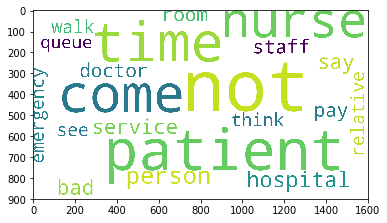

In [117]:
# Get a list of words for each comment about Rmathibodi Hospital

df_neg_rama_str_sigmoid = df_neg_rama_sigmoid['final_sen'].str.split()
index = df_neg_rama_str_sigmoid.index

df_neg_rama_str_term_sigmoid = []
for i in index:
    for j in range(len(df_neg_rama_str_sigmoid[i])):
        df_neg_rama_str_term_sigmoid.append(df_neg_rama_str_sigmoid[i][j])

df_neg_rama_str_tf_LSTM = Counter(df_neg_rama_str_term_sigmoid)

w = WordCloud(width=1600,height=900,mode='RGBA',background_color='white',max_words=20).fit_words(df_neg_rama_str_tf_LSTM)
plt.imshow(w)
plt.show()

In [118]:
df_neg_rama_str_tf_LSTM.most_common(20)

[('not', 23),
 ('patient', 14),
 ('time', 13),
 ('come', 12),
 ('nurse', 11),
 ('person', 11),
 ('hospital', 9),
 ('say', 8),
 ('service', 8),
 ('bad', 8),
 ('doctor', 7),
 ('room', 7),
 ('pay', 7),
 ('staff', 7),
 ('walk', 6),
 ('emergency', 6),
 ('see', 6),
 ('think', 6),
 ('relative', 6),
 ('queue', 6)]

According to the wordcloud, the negative words that are mostly written in the about are about time queue payment and emergency.

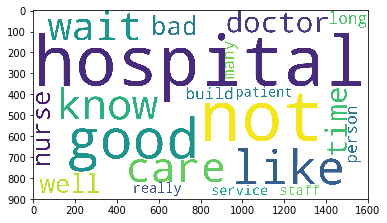

In [111]:
# Get a list of words for each comment about Chula Hospital

df_neg_chula_str_sigmoid = df_neg_chula_sigmoid['final_sen'].str.split()
index = df_neg_chula_str_sigmoid.index

df_neg_chula_str_term_sigmoid = []
for i in index:
    for j in range(len(df_neg_chula_str_sigmoid[i])):
        df_neg_chula_str_term_sigmoid.append(df_neg_chula_str_sigmoid[i][j])

df_neg_chula_str_tf_LSTM = Counter(df_neg_chula_str_term_sigmoid)

w = WordCloud(width=1600,height=900,mode='RGBA',background_color='white',max_words=20).fit_words(df_neg_chula_str_tf_LSTM)
plt.imshow(w)
plt.show()

In [119]:
df_neg_chula_str_tf_LSTM.most_common(20)

[('hospital', 12),
 ('not', 12),
 ('good', 7),
 ('like', 5),
 ('know', 4),
 ('care', 4),
 ('wait', 4),
 ('doctor', 4),
 ('time', 4),
 ('well', 3),
 ('bad', 3),
 ('nurse', 3),
 ('long', 3),
 ('person', 3),
 ('many', 3),
 ('build', 3),
 ('really', 3),
 ('patient', 3),
 ('staff', 3),
 ('service', 3)]

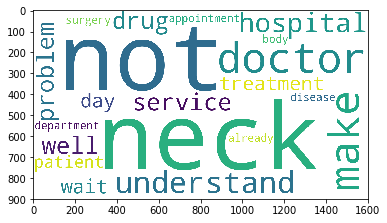

In [113]:
# Get a list of words for each comment about Siriaj Hospital

df_neg_siriraj_str_sigmoid = df_neg_siriraj_sigmoid['final_sen'].str.split()
index = df_neg_siriraj_str_sigmoid.index

df_neg_siriraj_str_term_sigmoid = []
for i in index:
    for j in range(len(df_neg_siriraj_str_sigmoid[i])):
        df_neg_siriraj_str_term_sigmoid.append(df_neg_siriraj_str_sigmoid[i][j])

df_neg_siriraj_str_tf_LSTM = Counter(df_neg_siriraj_str_term_sigmoid)

w = WordCloud(width=1600,height=900,mode='RGBA',background_color='white',max_words=20).fit_words(df_neg_siriraj_str_tf_LSTM)
plt.imshow(w)
plt.show()

In [120]:
df_neg_siriraj_str_tf_LSTM.most_common(20)

[('neck', 5),
 ('not', 5),
 ('doctor', 4),
 ('make', 4),
 ('understand', 4),
 ('hospital', 4),
 ('well', 3),
 ('service', 3),
 ('drug', 3),
 ('problem', 3),
 ('treatment', 2),
 ('day', 2),
 ('wait', 2),
 ('patient', 2),
 ('appointment', 2),
 ('already', 2),
 ('department', 2),
 ('disease', 2),
 ('surgery', 2),
 ('body', 2)]

## <i> Limitation

The limitation of this study is mostly due to low number of samples. There samples in this assignment are less than 350 samples. Also, the accuracy and loss in validation set doesn't perform well and it seems to be overfit. Moreover, there are some mistranslated words as some Thai words are ambigious and difficult to translate.

## <i> Conclusion



<div style="text-align: justify">The model that has the highest prediction accuracy is LSTM model. Pretain GloVe word embedding helps stabilize the accuracy and loss significantly and increase the speed getting the optimal weight faster. GloVe doesn't help in improving the accuracy, but we didn't perform gridsearch to find the best architecture for LSTM with GloVe which might be able to improve the accuracy. We could add more dropout layers or increase the dropout rate in order to prevent overfit of the model.</div>

<br>

<div style="text-align: justify">The incorrect prediction mostly are due to incorrect translation from Thai to English, ambugious comments as it contain both negative and positive opinions and incorrect label from grouping the comemnt. This can be improve by change the binary labels into multiclass label but we need to have more negative and neutral samples. Moreover, having better Thai to English translation would improve the model significantly as there are many incorrect translated words. We could try Thai tokenizer and use Thai words to create sentiment classificaition model which could remove risk of Thai to English translation error.</div>

<br>

<div style="text-align: justify">Acoording to the wordcloud, many predicted negative comments in Ramathibodi hospital are mention about time , queue, emergency and service. For Chulalongkorn hospital, most of the word are about wait and time. Lastly, Siriraj hospital has comment mostly aboutneck, wait, appointment which could be use for improvement.</div>

